In [1]:
%run "MongoDB_Connections.ipynb"
%run "MongoDB_Funciones_Consultas.ipynb"

from ipynb.fs.full.MongoDB_Connections import _connect_mongo

from ipynb.fs.full.MongoDB_Funciones_Consultas import _resumen_mensual_por_anio
from ipynb.fs.full.MongoDB_Funciones_Consultas import _data_anio
from ipynb.fs.full.MongoDB_Funciones_Consultas import _data_anio_mes
from ipynb.fs.full.MongoDB_Funciones_Consultas import _data_anio_por_estacion
from ipynb.fs.full.MongoDB_Funciones_Consultas import _data_anio_mes_por_estacion
from ipynb.fs.full.MongoDB_Funciones_Consultas import _consulta_meteoUS_full
from ipynb.fs.full.MongoDB_Funciones_Consultas import _consulta_meteoUS_por_anio
from ipynb.fs.full.MongoDB_Funciones_Consultas import _consulta_meteoUS_por_anio_mes

from ipynb.fs.full.MongoDB_Funciones_Consultas import _consulta_stations
from ipynb.fs.full.MongoDB_Funciones_Consultas import _consulta_stations_EstacionesMeteo

import time
import pandas as pd
pd.options.display.float_format = '{:,}'.format

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('darkgrid')
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, plot_confusion_matrix

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Conexión a Mongo

In [3]:
db_Tracks = _connect_mongo('cloud', 'cluster0.15npsxw.mongodb.net', None, 'ucmtfm2022', 'UCM_2022', 'BiciMAD', 'Tracks_Demanda')
db_Meteo = _connect_mongo('cloud', 'cluster0.15npsxw.mongodb.net', None, 'ucmtfm2022', 'UCM_2022', 'BiciMAD', 'Meteo_US_NivelHora')
db_Stations = _connect_mongo('cloud', 'cluster0.15npsxw.mongodb.net', None, 'ucmtfm2022', 'UCM_2022', 'BiciMAD', 'Estaciones')
db_Stations_Meteo = _connect_mongo('cloud', 'cluster0.15npsxw.mongodb.net', None, 'ucmtfm2022', 'UCM_2022', 'BiciMAD', 'Station_EstacionMeteo')
db_Demografia = _connect_mongo('cloud', 'cluster0.15npsxw.mongodb.net', None, 'ucmtfm2022', 'UCM_2022', 'BiciMAD', 'Demografia')

Conexion OK
Collection(Database(MongoClient(host=['ac-x1d17w2-shard-00-00.15npsxw.mongodb.net:27017', 'ac-x1d17w2-shard-00-01.15npsxw.mongodb.net:27017', 'ac-x1d17w2-shard-00-02.15npsxw.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, authsource='admin', replicaset='atlas-xyv6ql-shard-0', tls=True, serverselectiontimeoutms=4000, tlscafile='C:\\Users\\fabio\\anaconda3\\lib\\site-packages\\certifi\\cacert.pem'), 'BiciMAD'), 'Tracks_Demanda')
Conexion OK
Collection(Database(MongoClient(host=['ac-x1d17w2-shard-00-00.15npsxw.mongodb.net:27017', 'ac-x1d17w2-shard-00-01.15npsxw.mongodb.net:27017', 'ac-x1d17w2-shard-00-02.15npsxw.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, authsource='admin', replicaset='atlas-xyv6ql-shard-0', tls=True, serverselectiontimeoutms=4000, tlscafile='C:\\Users\\fabio\\anaconda3\\lib\\site-packages\\certifi\\cacert.pem'), 'BiciMAD'), 'Meteo_US_NivelHora')
Conexion OK
Collection(Database(MongoClient(host=['ac-x1d17w2-

In [4]:
find_five = db_Meteo.find().limit(5)
print(list(find_five))

[{'_id': ObjectId('6300ee722a649ee1b5331999'), 'dt_iso': '2017-01-01 00:00:00 +0000 UTC', 'temp': -3.42, 'feels_like': -5.73, 'pressure': 1030, 'humidity': 93, 'wind_speed': 1.54, 'weather_id': 800, 'weather_main': 'Clear', 'weather_description': 'sky is clear', 'rain_1h': 0, 'rain_3h': 0, 'snow_1h': 0, 'snow_3h': 0, 'ANIO': 2017, 'MES': 1, 'DIA': 1, 'HORA': 0}, {'_id': ObjectId('6300ee722a649ee1b533199a'), 'dt_iso': '2017-01-01 01:00:00 +0000 UTC', 'temp': -4.42, 'feels_like': -4.42, 'pressure': 1029, 'humidity': 93, 'wind_speed': 1.03, 'weather_id': 800, 'weather_main': 'Clear', 'weather_description': 'sky is clear', 'rain_1h': 0, 'rain_3h': 0, 'snow_1h': 0, 'snow_3h': 0, 'ANIO': 2017, 'MES': 1, 'DIA': 1, 'HORA': 1}, {'_id': ObjectId('6300ee722a649ee1b533199b'), 'dt_iso': '2017-01-01 02:00:00 +0000 UTC', 'temp': -4.42, 'feels_like': -4.42, 'pressure': 1028, 'humidity': 93, 'wind_speed': 0.51, 'weather_id': 802, 'weather_main': 'Clouds', 'weather_description': 'scattered clouds', 'rai

## Descarga datos

In [32]:
data_Tracks_2017 = _data_anio(db_Tracks, 2017)

In [33]:
df=data_Tracks_2017[data_Tracks_2017['Es_Festivo']==1]

In [34]:
df.groupby(['ANIO', 'MES', 'DIA']).count()

HORA  DIA_SEMANA  AM_PM  TEMPORADA  UNPLUG_TIME_date  \
ANIO MES DIA                                                          
2017 4   13    5041        5041   5041       5041              5041   
         14    4857        4857   4857       4857              4857   
     5   1     6046        6046   6046       6046              6046   
         2     7563        7563   7563       7563              7563   
         15    8514        8514   8514       8514              8514   
     8   15    7172        7172   7172       7172              7172   
     10  12   11150       11150  11150      11150             11150   
     11  1    11249       11249  11249      11249             11249   
         9     8337        8337   8337       8337              8337   
     12  6     6849        6849   6849       6849              6849   
         8     6014        6014   6014       6014              6014   
         25    2725        2725   2725       2725              2725   

              travel_time  idunplug_station  user_type  ageRange  zip_code  \
ANIO MES DIA                                                                 
2017 4   13          5041              5041       5041      5041      5041   
         14          4857              4857       4857      4857      4857   
     5   1           6046              6046       6046      6046      6046   
         2           7563              7563       7563      7563      7563   
         15          8514              8514       8514      8514      8514   
     8   15          7172              7172       7172      7172      7172   
     10  12         11150             11150      11150     11150     11150   
     11  1          11249             11249      11249     11249     11249   
         9           8337              8337       8337      8337      8337   
     12  6           6849              6849       6849      6849      6849   
         8           6014              6014       6014      6014      6014   
         25          2725              2725       2725      2725      2725   

              Es_Festivo  Es_FinSemana  DEMANDA  
ANIO MES DIA                                     
2017 4   13         5041          5041     5041  
         14         4857          4857     4857  
     5   1          6046          6046     6046  
         2          7563          7563     7563  
         15         8514          8514     8514  
     8   15         7172          7172     7172  
     10  12        11150         11150    11150  
     11  1         11249         11249    11249  
         9          8337          8337     8337  
     12  6          6849          6849     6849  
         8          6014          6014     6014  
         25         2725          2725     2725

In [35]:
# Tracks
t_ini = time.time()
data_Tracks_2017 = _data_anio(db_Tracks, 2017)
data_Tracks_2018 = _data_anio(db_Tracks, 2018)
data_Tracks_2019 = _data_anio(db_Tracks, 2019)
data_Tracks_2020 = _data_anio(db_Tracks, 2020)
data_Tracks_2021 = _data_anio(db_Tracks, 2021)
t_end = time.time()

print ((t_end - t_ini)/60)

data_Tracks = pd.concat([
    data_Tracks_2017,
    data_Tracks_2018,
    data_Tracks_2019,
    data_Tracks_2020,
    data_Tracks_2021
])

data_Tracks.shape

10.192182576656341


(13780517, 16)

In [36]:
data_Tracks.to_csv('C:/Users/fabio/GitHub/Python Notebooks/Data/data_meteo.csv', index=False)

In [37]:
data_Tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13780517 entries, 0 to 3356426
Data columns (total 16 columns):
 #   Column            Dtype         
---  ------            -----         
 0   ANIO              int64         
 1   MES               int64         
 2   DIA               int64         
 3   HORA              int64         
 4   DIA_SEMANA        int64         
 5   AM_PM             object        
 6   TEMPORADA         object        
 7   UNPLUG_TIME_date  datetime64[ns]
 8   travel_time       int64         
 9   idunplug_station  int64         
 10  user_type         int64         
 11  ageRange          int64         
 12  zip_code          object        
 13  Es_Festivo        int64         
 14  Es_FinSemana      int64         
 15  DEMANDA           int64         
dtypes: datetime64[ns](1), int64(12), object(3)
memory usage: 1.7+ GB


In [5]:
t_ini = time.time()
data_Tracks = pd.read_csv('C:/Users/fabio/GitHub/Python Notebooks/Data/data_meteo.csv')
t_end = time.time()
print (t_end - t_ini)

20.701273441314697


In [6]:
# t_ini = time.time()
# data_Tracks_2017 = _data_anio_por_estacion(db_Tracks, 2017, 175)
# data_Tracks_2018 = _data_anio_por_estacion(db_Tracks, 2018, 175)
# data_Tracks_2019 = _data_anio_por_estacion(db_Tracks, 2019, 175)
# data_Tracks_2020 = _data_anio_por_estacion(db_Tracks, 2020, 175)
# data_Tracks_2021 = _data_anio_por_estacion(db_Tracks, 2021, 175)
# t_end = time.time()

# data_Tracks = pd.concat([
#     data_Tracks_2017,
#     data_Tracks_2018,
#     data_Tracks_2019,
#     data_Tracks_2020,
#     data_Tracks_2021
# ])

# print ((t_end - t_ini)/60)

In [7]:
#data_Tracks = _data_anio(db_Tracks, 2019)  --> escoger el año de 2019

In [8]:
data_Tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13780517 entries, 0 to 13780516
Data columns (total 16 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   ANIO              int64 
 1   MES               int64 
 2   DIA               int64 
 3   HORA              int64 
 4   DIA_SEMANA        int64 
 5   AM_PM             object
 6   TEMPORADA         object
 7   UNPLUG_TIME_date  object
 8   travel_time       int64 
 9   idunplug_station  int64 
 10  user_type         int64 
 11  ageRange          int64 
 12  zip_code          object
 13  Es_Festivo        int64 
 14  Es_FinSemana      int64 
 15  DEMANDA           int64 
dtypes: int64(12), object(4)
memory usage: 1.6+ GB


In [9]:
# Meteorologia
t_ini = time.time()
#data_Meteo = _consulta_meteoUS_por_anio(db_Meteo, 2020)
data_Meteo = _consulta_meteoUS_full(db_Meteo)
t_end = time.time()

print (t_end - t_ini)
data_Meteo


1.7984058856964111


,ANIO,MES,DIA,HORA,TEMPERATURA,TEMP_SENS_TERMC,VIENTO,PRESION,HUMEDAD,PRECIPITACION_1h,PRECIPITACION_3h,NIEVE_1h,NIEVE_3h,ID_TIPO_TIEMPO,DESC_TIEMPO,DESC_TIEMPO_detalle
0,2017,1,1,0,-3.42,-5.73,1.54,1030,93,0.0,0.0,0.0,0.0,800,Clear,sky is clear
1,2017,1,1,1,-4.42,-4.42,1.03,1029,93,0.0,0.0,0.0,0.0,800,Clear,sky is clear
2,2017,1,1,2,-4.42,-4.42,0.51,1028,93,0.0,0.0,0.0,0.0,802,Clouds,scattered clouds
3,2017,1,1,3,-3.42,-3.42,1.03,1028,86,0.0,0.0,0.0,0.0,803,Clouds,broken clouds
4,2017,1,1,4,-2.42,-6.5,3.1,1028,86,0.0,0.0,0.0,0.0,803,Clouds,broken clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50129,2022,8,14,5,18.58,18.27,2.57,1014,68,0.0,0.0,0.0,0.0,800,Clear,sky is clear
50130,2022,8,14,6,18.38,18.08,1.03,1014,69,0.0,0.0,0.0,0.0,800,Clear,sky is clear
50131,2022,8,14,7,20.14,19.7,1.03,1014,57,0.0,0.0,0.0,0.0,800,Clear,sky is clear
50132,2022,8,14,8,21.69,21.32,2.57,1014,54,0.0,0.0,0.0,0.0,800,Clear,sky is clear


In [10]:
# Stations
t_ini = time.time()
data_Stations = _consulta_stations(db_Stations)
t_end = time.time()

print (t_end - t_ini)
data_Stations


0.2483372688293457


,Id_Estacion,Nro_Estacion,Gis_X,Gis_Y,Fec_Alta,Distrito,Distrito_Nombre,Barrio,Barrio_Nombre,Calle,Finca,Tipo_Reserva,Plazas,Longitud,Latitud,Direccion
0,1,001 a,"440443,61","4474290,65",43803,1,CENTRO,01-06,SOL,"ALCALA, CALLE, DE",2,BiciMAD,30,-3.701998,40.4171107,"ALCALA, CALLE, DE, 2"
1,6,5,"440447,06","4475539,6",41813,1,CENTRO,01-04,JUSTICIA,"FUENCARRAL, CALLE, DE",106,BiciMAD,27,-3.7020743,40.428362,"FUENCARRAL, CALLE, DE, 106"
2,15,14,"439486,2","4475284,13",44045,9,MONCLOA-ARAVACA,09-02,ARGUELLES,"VENTURA RODRIGUEZ, CALLE, DE",1,BiciMAD,24,-3.7133768,40.4259913,"VENTURA RODRIGUEZ, CALLE, DE, 1"
3,16,15,"439996,77","4475313,59",43881,1,CENTRO,01-05,UNIVERSIDAD,"NORTE, CALLE, DEL",10,BiciMAD,21,-3.7073611,40.4262937,"NORTE, CALLE, DEL, 10"
4,21,020 ampliacion,"441014,52","4474516,49",43291,1,CENTRO,01-04,JUSTICIA,"ALCALA, CALLE, DE",49,BiciMAD,6,-3.6952901,40.4191858,"ALCALA, CALLE, DE, 49"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,238,230,"444952,82","4477207,59",44181,15,CIUDAD LINEAL,15-05,SAN PASCUAL,"CARLOTA O'NEILL, CALLE, DE",32,BiciMAD,24,-3.6491034,40.4436986,"CARLOTA O'NEILL, CALLE, DE, 32"
260,244,236,"439149,84","4473225,71",44181,2,ARGANZUELA,02-01,IMPERIAL,"IMPERIAL, PASEO",20,BiciMAD,24,-3.7171449,40.4074236,"IMPERIAL, PASEO, 20"
261,270,247,"441238,82","4476643,99",44194,7,CHAMBERi,07-05,RiOS ROSAS,"ZURBANO, CALLE, DE",90,BiciMAD,24,-3.692843,40.4383672,"ZURBANO, CALLE, DE, 90"
262,265,257,"438063,25","4476718,06",44194,9,MONCLOA-ARAVACA,09-03,CIUDAD UNIVERSITARIA,"JUAN DE HERRERA, AVENIDA, DE",1,BiciMAD,24,-3.73029,40.438804,"JUAN DE HERRERA, AVENIDA, DE, 1"


In [11]:
# Stations_Meteo
t_ini = time.time()
data_StationsMeteo = _consulta_stations_EstacionesMeteo(db_Stations_Meteo)
t_end = time.time()

print (t_end - t_ini)
data_StationsMeteo


0.20286965370178223


,Id_Station,Id_EstacionMeteo,Nro_Station,Nom_EstacionMeteo
0,10,28079110,9,J.M.D.Centro
1,1,28079035,001 a,Plaza del Carmen
2,14,28079004,13,Plaza Espa�a
3,15,28079004,14,Plaza Espa�a
4,18,28079035,17,Plaza del Carmen
...,...,...,...,...
259,252,28079038,244,Cuatro Caminos
260,270,28079109,247,J.M.D.Chamberi
261,258,28079109,250,J.M.D.Chamberi
262,261,28079038,253,Cuatro Caminos


In [12]:
###### Demografía ########
t_ini = time.time()
data_Demografia = _consulta_stations_EstacionesMeteo(db_Demografia)
t_end = time.time()

print (t_end - t_ini)
data_StationsMeteo

0.22450637817382812


,Id_Station,Id_EstacionMeteo,Nro_Station,Nom_EstacionMeteo
0,10,28079110,9,J.M.D.Centro
1,1,28079035,001 a,Plaza del Carmen
2,14,28079004,13,Plaza Espa�a
3,15,28079004,14,Plaza Espa�a
4,18,28079035,17,Plaza del Carmen
...,...,...,...,...
259,252,28079038,244,Cuatro Caminos
260,270,28079109,247,J.M.D.Chamberi
261,258,28079109,250,J.M.D.Chamberi
262,261,28079038,253,Cuatro Caminos


In [13]:
data_Tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13780517 entries, 0 to 13780516
Data columns (total 16 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   ANIO              int64 
 1   MES               int64 
 2   DIA               int64 
 3   HORA              int64 
 4   DIA_SEMANA        int64 
 5   AM_PM             object
 6   TEMPORADA         object
 7   UNPLUG_TIME_date  object
 8   travel_time       int64 
 9   idunplug_station  int64 
 10  user_type         int64 
 11  ageRange          int64 
 12  zip_code          object
 13  Es_Festivo        int64 
 14  Es_FinSemana      int64 
 15  DEMANDA           int64 
dtypes: int64(12), object(4)
memory usage: 1.6+ GB


In [14]:
data_Meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50134 entries, 0 to 50133
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ANIO                 50134 non-null  int64  
 1   MES                  50134 non-null  int64  
 2   DIA                  50134 non-null  int64  
 3   HORA                 50134 non-null  int64  
 4   TEMPERATURA          50134 non-null  float64
 5   TEMP_SENS_TERMC      50134 non-null  float64
 6   VIENTO               50134 non-null  float64
 7   PRESION              50134 non-null  int64  
 8   HUMEDAD              50134 non-null  int64  
 9   PRECIPITACION_1h     50134 non-null  float64
 10  PRECIPITACION_3h     50134 non-null  float64
 11  NIEVE_1h             50134 non-null  float64
 12  NIEVE_3h             50134 non-null  float64
 13  ID_TIPO_TIEMPO       50134 non-null  int64  
 14  DESC_TIEMPO          50134 non-null  object 
 15  DESC_TIEMPO_detalle  50134 non-null 

In [15]:
data_Stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id_Estacion      264 non-null    int64  
 1   Nro_Estacion     264 non-null    object 
 2   Gis_X            264 non-null    object 
 3   Gis_Y            264 non-null    object 
 4   Fec_Alta         264 non-null    int64  
 5   Distrito         264 non-null    int64  
 6   Distrito_Nombre  264 non-null    object 
 7   Barrio           264 non-null    object 
 8   Barrio_Nombre    264 non-null    object 
 9   Calle            264 non-null    object 
 10  Finca            264 non-null    object 
 11  Tipo_Reserva     264 non-null    object 
 12  Plazas           264 non-null    int64  
 13  Longitud         264 non-null    float64
 14  Latitud          264 non-null    float64
 15  Direccion        264 non-null    object 
dtypes: float64(2), int64(4), object(10)
memory usage: 33.1+ KB


In [16]:
data_StationsMeteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Id_Station         264 non-null    int64 
 1   Id_EstacionMeteo   264 non-null    int64 
 2   Nro_Station        264 non-null    object
 3   Nom_EstacionMeteo  264 non-null    object
dtypes: int64(2), object(2)
memory usage: 8.4+ KB


In [17]:
data_Demografia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Distrito             131 non-null    int64 
 1   Distrito_Nombre      131 non-null    object
 2   Barrio               131 non-null    object
 3   Barrio_Nombre        131 non-null    object
 4   Tasa_Paro            131 non-null    object
 5   Renta_Media_Persona  131 non-null    object
 6   Renta_Media_Hogar    131 non-null    object
 7   Poblacion            131 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 8.3+ KB


### Merge Data

In [18]:
#del data

In [19]:
data = pd.merge(data_Tracks, data_Stations, how='left', left_on='idunplug_station', right_on='Id_Estacion')

In [20]:
data.shape

(13780517, 32)

In [21]:
data1 = pd.merge(data, data_StationsMeteo, how='left', left_on='Id_Estacion', right_on='Id_Station')

In [22]:
data_final = pd.merge(data1, data_Meteo, how='left', left_on=['ANIO','MES','DIA','HORA'], 
                      right_on=['ANIO','MES','DIA','HORA'])

In [23]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13897753 entries, 0 to 13897752
Data columns (total 48 columns):
 #   Column               Dtype  
---  ------               -----  
 0   ANIO                 int64  
 1   MES                  int64  
 2   DIA                  int64  
 3   HORA                 int64  
 4   DIA_SEMANA           int64  
 5   AM_PM                object 
 6   TEMPORADA            object 
 7   UNPLUG_TIME_date     object 
 8   travel_time          int64  
 9   idunplug_station     int64  
 10  user_type            int64  
 11  ageRange             int64  
 12  zip_code             object 
 13  Es_Festivo           int64  
 14  Es_FinSemana         int64  
 15  DEMANDA              int64  
 16  Id_Estacion          float64
 17  Nro_Estacion         object 
 18  Gis_X                object 
 19  Gis_Y                object 
 20  Fec_Alta             float64
 21  Distrito             float64
 22  Distrito_Nombre      object 
 23  Barrio               object 
 

In [24]:
data.shape

(13780517, 32)

In [25]:
data.groupby(['Id_Estacion', 'ANIO', 'MES']).size()

Id_Estacion  ANIO  MES
1.0          2017  3         7
                   4      2340
                   5      3010
                   6      3012
                   7      3338
                          ... 
266.0        2020  12        5
267.0        2020  12       18
268.0        2020  12       10
269.0        2020  12       66
270.0        2020  12       30
Length: 8541, dtype: int64

In [26]:
pd.set_option("display.max_columns", None)
data_final.head(10)

,ANIO,MES,DIA,HORA,DIA_SEMANA,AM_PM,TEMPORADA,UNPLUG_TIME_date,travel_time,idunplug_station,user_type,ageRange,zip_code,Es_Festivo,Es_FinSemana,DEMANDA,Id_Estacion,Nro_Estacion,Gis_X,Gis_Y,Fec_Alta,Distrito,Distrito_Nombre,Barrio,Barrio_Nombre,Calle,Finca,Tipo_Reserva,Plazas,Longitud,Latitud,Direccion,Id_Station,Id_EstacionMeteo,Nro_Station,Nom_EstacionMeteo,TEMPERATURA,TEMP_SENS_TERMC,VIENTO,PRESION,HUMEDAD,PRECIPITACION_1h,PRECIPITACION_3h,NIEVE_1h,NIEVE_3h,ID_TIPO_TIEMPO,DESC_TIEMPO,DESC_TIEMPO_detalle
0,2017,3,31,23,6,PM,INVIERNO,2017-03-31 23:00:00,1046,10,1,3,28053,0,0,1,10.0,9,"439813,51","4474129,47","41,813.0",1.0,CENTRO,01-01,PALACIO,"SAN MIGUEL, PLAZA, DE",9,BiciMAD,24.0,-3.7094093,40.4156134,"SAN MIGUEL, PLAZA, DE, 9",10.0,"28,079,110.0",9,J.M.D.Centro,12.58,11.04,7.72,1020,44,0.0,0.0,0.0,0.0,801,Clouds,few clouds
1,2017,3,31,23,6,PM,INVIERNO,2017-03-31 23:00:00,1377,10,1,3,28007,0,0,1,10.0,9,"439813,51","4474129,47","41,813.0",1.0,CENTRO,01-01,PALACIO,"SAN MIGUEL, PLAZA, DE",9,BiciMAD,24.0,-3.7094093,40.4156134,"SAN MIGUEL, PLAZA, DE, 9",10.0,"28,079,110.0",9,J.M.D.Centro,12.58,11.04,7.72,1020,44,0.0,0.0,0.0,0.0,801,Clouds,few clouds
2,2017,3,31,23,6,PM,INVIERNO,2017-03-31 23:00:00,497,102,1,4,28007,0,0,1,102.0,97,"442301,64","4474872,66","41,813.0",4.0,SALAMANCA,04-02,GOYA,"MENENDEZ PELAYO, AVENIDA, DE",1,BiciMAD,27.0,-3.6801515,40.4224846,"MENENDEZ PELAYO, AVENIDA, DE, 1",102.0,"28,079,111.0",97,J.M.D.Chamartin,12.58,11.04,7.72,1020,44,0.0,0.0,0.0,0.0,801,Clouds,few clouds
3,2017,3,31,23,6,PM,INVIERNO,2017-03-31 23:00:00,639,108,1,2,28009,0,0,1,108.0,103,"441766,91","4475752,49","41,813.0",4.0,SALAMANCA,04-06,CASTELLANA,"JOSE ORTEGA Y GASSET, CALLE, DE",4,BiciMAD,24.0,-3.6865351,40.4303733,"JOSE ORTEGA Y GASSET, CALLE, DE, 4",108.0,"28,079,109.0",103,J.M.D.Chamberi,12.58,11.04,7.72,1020,44,0.0,0.0,0.0,0.0,801,Clouds,few clouds
4,2017,3,31,23,6,PM,INVIERNO,2017-03-31 23:00:00,761,109,1,3,28029,0,0,1,109.0,104,"441505,58","4475354,07","41,813.0",4.0,SALAMANCA,04-01,RECOLETOS,"CASTELLANA, PASEO, DE LA",4,BiciMAD,21.0,-3.6895792,40.4267658,"CASTELLANA, PASEO, DE LA, 4",109.0,"28,079,008.0",104,Escuelas Aguirre,12.58,11.04,7.72,1020,44,0.0,0.0,0.0,0.0,801,Clouds,few clouds
5,2017,3,31,23,6,PM,INVIERNO,2017-03-31 23:00:00,644,110,1,4,28004,0,0,1,110.0,105,"441684,37","4475386,27","41,813.0",4.0,SALAMANCA,04-01,RECOLETOS,"SERRANO, CALLE, DE",46,BiciMAD,24.0,-3.6874745,40.4270684,"SERRANO, CALLE, DE, 46",110.0,"28,079,008.0",105,Escuelas Aguirre,12.58,11.04,7.72,1020,44,0.0,0.0,0.0,0.0,801,Clouds,few clouds
6,2017,3,31,23,6,PM,INVIERNO,2017-03-31 23:00:00,592,113,1,3,28020,0,0,1,113.0,107,"441599,07","4474779,37","41,813.0",4.0,SALAMANCA,04-01,RECOLETOS,"SERRANO, CALLE, DE",8,BiciMAD,24.0,-3.6884243,40.4215952,"SERRANO, CALLE, DE, 8",113.0,"28,079,008.0",107,Escuelas Aguirre,12.58,11.04,7.72,1020,44,0.0,0.0,0.0,0.0,801,Clouds,few clouds
7,2017,3,31,23,6,PM,INVIERNO,2017-03-31 23:00:00,1000,116,1,3,28001,0,0,1,116.0,110,"438921,15","4476262,7","41,813.0",9.0,MONCLOA-ARAVACA,09-01,CASA DE CAMPO,"MORET, PASEO, DE",S/N,BiciMAD,24.0,-3.7201316,40.4347654,"MORET, PASEO, DE, S/N",116.0,"28,079,004.0",110,Plaza Espa�a,12.58,11.04,7.72,1020,44,0.0,0.0,0.0,0.0,801,Clouds,few clouds
8,2017,3,31,23,6,PM,INVIERNO,2017-03-31 23:00:00,670,118,1,3,28013,0,0,1,118.0,111 b,"439120,04","4476174,12","41,813.0",7.0,CHAMBERi,07-01,GAZTAMBIDE,"ARCIPRESTE DE HITA, CALLE, DEL",12,BiciMAD,24.0,-3.7177783,40.433982,"ARCIPRESTE DE HITA, CALLE, DEL, 12",118.0,"28,079,004.0",111 b,Plaza Espa�a,12.58,11.04,7.72,1020,44,0.0,0.0,0.0,0.0,801,Clouds,few clouds
9,2017,3,31,23,6,PM,INVIERNO,2017-03-31 23:00:00,350,120,1,4,28015,0,0,1,120.0,113,"438865,35","4475484,09","41,813.0",9.0,MONCLOA-ARAVACA,09-01,CASA DE CAMPO,"PINTOR ROSALES, PASEO, DEL",frente 38,BiciMAD,24.0,-3.7207145,40.4277472,"PINTOR ROSALES, PASEO, DEL, frente 38",120.0,"28,079,004.0",113,Plaza Espa�a,12.58,11.04,7.72,1020,44,0.0,0.0,0.0,0.0,801,Clouds,few clouds


# EDA - Datos Metereológicos

## 1. Datos Duplicados y Nulos (NAs)

In [43]:
data_final.dtypes

ANIO                     int64
MES                      int64
DIA                      int64
HORA                     int64
DIA_SEMANA               int64
AM_PM                   object
TEMPORADA               object
UNPLUG_TIME_date        object
travel_time              int64
idunplug_station         int64
user_type                int64
ageRange                 int64
zip_code                object
Es_Festivo               int64
Es_FinSemana             int64
DEMANDA                  int64
Id_Estacion            float64
Nro_Estacion            object
Gis_X                   object
Gis_Y                   object
Fec_Alta               float64
Distrito               float64
Distrito_Nombre         object
Barrio                  object
Barrio_Nombre           object
Calle                   object
Finca                   object
Tipo_Reserva            object
Plazas                 float64
Longitud               float64
Latitud                float64
Direccion               object
Id_Stati

In [38]:
data_final['ID_TIPO_TIEMPO'].unique()  # Este es una variable categorica, no es numérica. Pasarla a 

array([801., 800., 802., 500., 501., 803., 300., 211., 804., 701., 301.,
       741., 201., 520., 521., 200., 202., 502., 522., 615., 721., 601.,
       600., 611., 602., 311., 503., 310., 302., 711., 771.])

In [42]:
data_final['ID_TIPO_TIEMPO'] = data_final['ID_TIPO_TIEMPO'].astype(str)

In [44]:
"""Separaremos las variables categóricas metereológicas de las numéricas"""

num_cols = ['TEMPERATURA', 'TEMP_SENS_TERMC','VIENTO', 'PRESION', 'HUMEDAD', 'PRECIPITACION_1h','PRECIPITACION_3h',
            'NIEVE_1h', 'NIEVE_3h']
cat_cols = ['ID_TIPO_TIEMPO','DESC_TIEMPO', 'DESC_TIEMPO_detalle']
data_final[num_cols] = data_final[num_cols].astype(float)

In [45]:
"""Comprobar que no haya registros duplicados"""

# Duplicados
print('Valores duplicados: ', np.sum(data_final.duplicated()))

Valores duplicados:  0


In [46]:
"""Chequear los valores registros nulos"""
print("Valores nulos:")
print(data_final.isnull().sum())

Valores nulos:
ANIO                         0
MES                          0
DIA                          0
HORA                         0
DIA_SEMANA                   0
AM_PM                        0
TEMPORADA                    0
UNPLUG_TIME_date             0
travel_time                  0
idunplug_station             0
user_type                    0
ageRange                     0
zip_code               6400622
Es_Festivo                   0
Es_FinSemana                 0
DEMANDA                      0
Id_Estacion              52612
Nro_Estacion             52612
Gis_X                    52612
Gis_Y                    52612
Fec_Alta                 52612
Distrito                 52612
Distrito_Nombre          52612
Barrio                   52612
Barrio_Nombre            52612
Calle                    52612
Finca                    52612
Tipo_Reserva             52612
Plazas                   52612
Longitud                 52612
Latitud                  52612
Direccion               

In [47]:
# % Nulos
print("Porcentaje Nulos")
print(round(data_final.isnull().sum()/len(data_final)*100,2),"%")

Porcentaje Nulos
ANIO                    0.0
MES                     0.0
DIA                     0.0
HORA                    0.0
DIA_SEMANA              0.0
AM_PM                   0.0
TEMPORADA               0.0
UNPLUG_TIME_date        0.0
travel_time             0.0
idunplug_station        0.0
user_type               0.0
ageRange                0.0
zip_code              46.06
Es_Festivo              0.0
Es_FinSemana            0.0
DEMANDA                 0.0
Id_Estacion            0.38
Nro_Estacion           0.38
Gis_X                  0.38
Gis_Y                  0.38
Fec_Alta               0.38
Distrito               0.38
Distrito_Nombre        0.38
Barrio                 0.38
Barrio_Nombre          0.38
Calle                  0.38
Finca                  0.38
Tipo_Reserva           0.38
Plazas                 0.38
Longitud               0.38
Latitud                0.38
Direccion              0.38
Id_Station             0.38
Id_EstacionMeteo       0.38
Nro_Station            0.38
Nom

**CONCLUSIÓN**: No hay variables metereologicas nulas y registros duplicados.

## 2. Variables Numéricas

TEMPERATURA


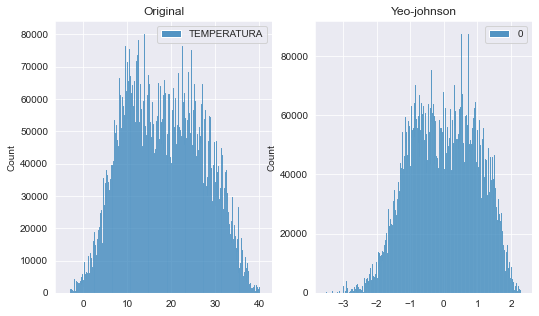

TEMP_SENS_TERMC


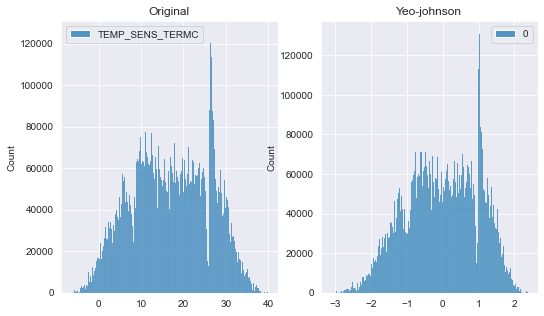

VIENTO


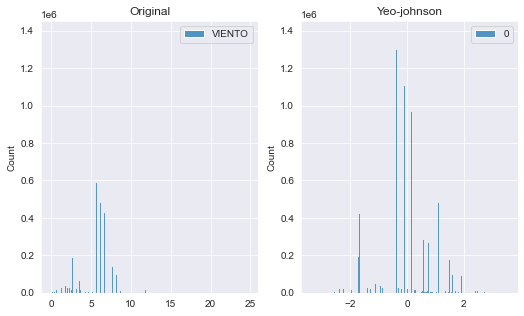

PRESION


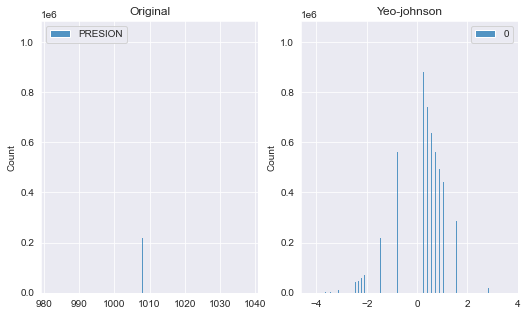

HUMEDAD


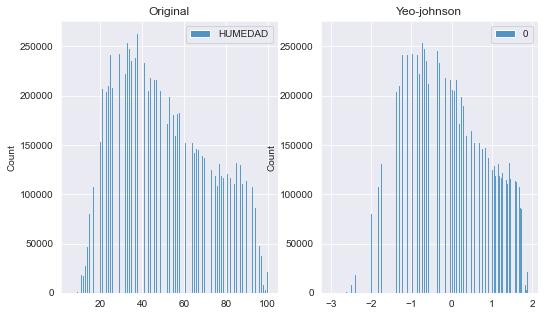

PRECIPITACION_1h


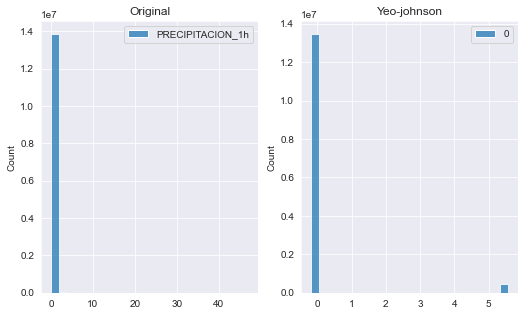

PRECIPITACION_3h


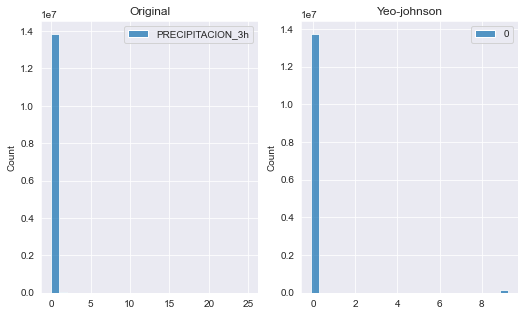

NIEVE_1h


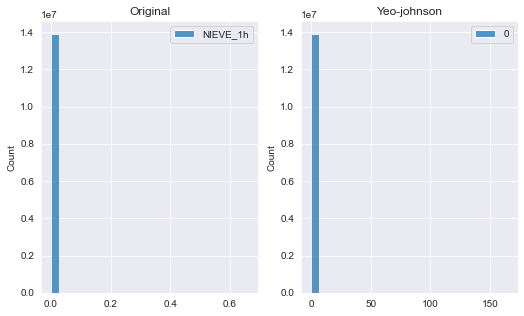

NIEVE_3h


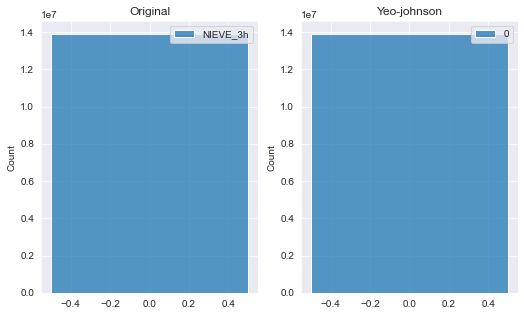

In [48]:
""" Mostrar 2 histogramas por cada variable numérica:
    - Uno con el valor de la variable 
    - Uno con el valor de la variable transformada por Yeo-Johnson """

pt = PowerTransformer(method='yeo-johnson')

for col in num_cols:
    X=data_final[[col]]
    X_new = pt.fit_transform(X)
    
    print(col)
    plt.figure(figsize=(13.2,5))
    plt.subplot(1,3,1)
    plt.title("Original")
    sns.histplot(X)
    plt.subplot(1,3,2)
    plt.title("Yeo-johnson")
    sns.histplot(X_new) 
    plt.show()

In [79]:
############################
### Datos sin agregación ###
############################

data_serie = data_final[['ANIO','MES','DIA','HORA','TEMPERATURA', 'TEMP_SENS_TERMC','VIENTO', 'PRESION', 'HUMEDAD', 'PRECIPITACION_1h','PRECIPITACION_3h',
            'NIEVE_1h', 'NIEVE_3h','ID_TIPO_TIEMPO','DESC_TIEMPO', 'DESC_TIEMPO_detalle','DEMANDA']]
data_serie['FECHA'] =pd.to_datetime({'year': data_serie['ANIO'],
                                          'month': data_serie["MES"]
                                          ,'day':  data_serie['DIA']
                                         # ,'hour':data_serie['HORA']
                                          },
                                          format='%d-%m-%Y', errors='coerce')
data_serie

,ANIO,MES,DIA,HORA,TEMPERATURA,TEMP_SENS_TERMC,VIENTO,PRESION,HUMEDAD,PRECIPITACION_1h,PRECIPITACION_3h,NIEVE_1h,NIEVE_3h,ID_TIPO_TIEMPO,DESC_TIEMPO,DESC_TIEMPO_detalle,DEMANDA,FECHA
0,2017,3,31,23,12.58,11.04,7.72,"1,020.0",44.0,0.0,0.0,0.0,0.0,801.0,Clouds,few clouds,1,2017-03-31
1,2017,3,31,23,12.58,11.04,7.72,"1,020.0",44.0,0.0,0.0,0.0,0.0,801.0,Clouds,few clouds,1,2017-03-31
2,2017,3,31,23,12.58,11.04,7.72,"1,020.0",44.0,0.0,0.0,0.0,0.0,801.0,Clouds,few clouds,1,2017-03-31
3,2017,3,31,23,12.58,11.04,7.72,"1,020.0",44.0,0.0,0.0,0.0,0.0,801.0,Clouds,few clouds,1,2017-03-31
4,2017,3,31,23,12.58,11.04,7.72,"1,020.0",44.0,0.0,0.0,0.0,0.0,801.0,Clouds,few clouds,1,2017-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13897748,2020,12,9,9,4.65,1.1,4.6,"1,021.0",72.0,0.0,0.0,0.0,0.0,800.0,Clear,sky is clear,1,2020-12-09
13897749,2020,12,9,9,4.65,1.1,4.6,"1,021.0",72.0,0.0,0.0,0.0,0.0,800.0,Clear,sky is clear,1,2020-12-09
13897750,2020,12,9,9,4.65,1.1,4.6,"1,021.0",72.0,0.0,0.0,0.0,0.0,800.0,Clear,sky is clear,1,2020-12-09
13897751,2020,12,9,9,4.65,1.1,4.6,"1,021.0",72.0,0.0,0.0,0.0,0.0,800.0,Clear,sky is clear,1,2020-12-09


In [52]:
###############################
### Datos agregados por día ###
###############################

data_serie_temp = data_serie.groupby(['FECHA']).agg(TEMPERATURA=('TEMPERATURA','mean'), TEMP_SENS_TERMC=('TEMP_SENS_TERMC','mean'),
                                                    VIENTO=('VIENTO','mean'), PRESION=('PRESION','mean'), HUMEDAD=('HUMEDAD','mean'),
                                                    PRECIPITACION_1h=('PRECIPITACION_1h','mean'), PRECIPITACION_3h=('PRECIPITACION_3h','mean'), 
                                                    NIEVE_1h=('NIEVE_1h','mean'), NIEVE_3h=('NIEVE_3h','mean'),
                                                    DEMANDA=('DEMANDA','sum'))   
data_serie_temp = data_serie_temp.reset_index()
data_serie_temp

,FECHA,TEMPERATURA,TEMP_SENS_TERMC,VIENTO,PRESION,HUMEDAD,PRECIPITACION_1h,PRECIPITACION_3h,NIEVE_1h,NIEVE_3h,DEMANDA
0,2017-03-31,12.579999999999952,11.03999999999997,7.71999999999998,"1,020.0",44.0,0.0,0.0,0.0,0.0,330
1,2017-04-01,13.34341108986613,11.55956022944492,6.880011472274997,"1,020.8407903123008",40.003186743148504,0.0,0.0,0.0,0.0,7917
2,2017-04-02,14.099594822735236,12.805118176703044,2.85459763646586,"1,020.9964828362408",40.4741136747327,0.0,0.0,0.0,0.0,7183
3,2017-04-03,13.88589829410426,12.103113798315828,2.0772047074065854,"1,022.8019866119629",36.92075145756856,0.0,0.0,0.0,0.0,9388
4,2017-04-04,16.428640165303882,15.196407556824482,2.6122877103214845,"1,022.0431959067205",33.350683853192955,0.0,0.0,0.0,0.0,10242
...,...,...,...,...,...,...,...,...,...,...,...
1293,2020-12-27,4.109593442623005,-0.22832131147541265,7.330998907103791,"1,010.623606557377",68.81245901639345,0.0,0.0,0.0,0.0,4583
1294,2020-12-28,6.92384365350215,2.4959401917763935,8.920630586705158,"1,002.9471802372826",55.34926052332196,0.026739801722736784,0.07149358036730039,0.0,0.0,6155
1295,2020-12-29,4.934183894752087,0.5815295648401799,6.741022119415318,"1,005.7987566864248",67.6414630620211,0.0,0.0,0.0,0.0,6932
1296,2020-12-30,5.147692934782468,1.7735312499998153,4.707930706521508,"1,015.6794836956522",59.12622282608696,0.0,0.0,0.0,0.0,7468


### a. EDA: 'TEMPERATURA'

In [49]:
data_serie['TEMPERATURA'].describe()

count         13,897,753.0
mean    18.265191788941546
std       8.78352182992693
min                  -4.12
25%                  11.09
50%                  17.91
75%                  25.18
max                  40.69
Name: TEMPERATURA, dtype: float64

In [50]:
"""Chequear si hay valores raros de temperatura muy negativas"""
print("num de obs. con Temperaura < -5°C =", data_serie.loc[data_serie['TEMPERATURA'] < -5]['ANIO'].count())
print("num de obs. con Temperaura < -10°C =", data_serie.loc[data_serie['TEMPERATURA'] < -10]['ANIO'].count())
print("num de obs. con Temperaura < -15°C =", data_serie.loc[data_serie['TEMPERATURA'] < -15]['ANIO'].count())
print("num de obs. con Temperaura < -20°C =", data_serie.loc[data_serie['TEMPERATURA'] < -20]['ANIO'].count())

num de obs. con Temperaura < -5°C = 0
num de obs. con Temperaura < -10°C = 0
num de obs. con Temperaura < -15°C = 0
num de obs. con Temperaura < -20°C = 0


In [32]:
"""Chequear si hay valores raros de temperatura muy altas"""
print("num de obs. con Temperaura > 42°C =", data_serie.loc[data_serie['TEMPERATURA'] > 42]['ANIO'].count())
print("num de obs. con Temperaura > 44°C =", data_serie.loc[data_serie['TEMPERATURA'] > 43]['ANIO'].count())
print("num de obs. con Temperaura > 46°C =", data_serie.loc[data_serie['TEMPERATURA'] > 44]['ANIO'].count())
print("num de obs. con Temperaura > 48°C =", data_serie.loc[data_serie['TEMPERATURA'] > 45]['ANIO'].count())

num de obs. con Temperaura > 42°C = 0
num de obs. con Temperaura > 44°C = 0
num de obs. con Temperaura > 46°C = 0
num de obs. con Temperaura > 48°C = 0


<AxesSubplot:title={'center':'TEMPERATURA'}, xlabel='MES'>

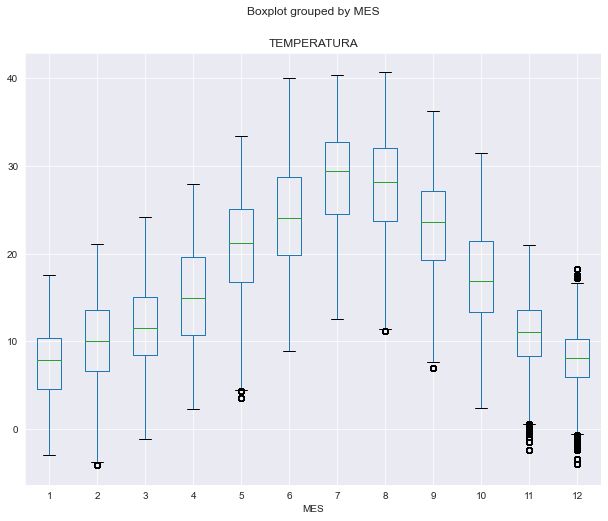

In [33]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
data_serie.boxplot('TEMPERATURA', by='MES', ax=ax)

<AxesSubplot:xlabel='MES', ylabel='TEMPERATURA'>

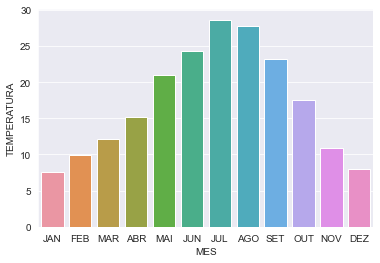

In [34]:
data_mes = data_serie[['MES','TEMPERATURA']]
data_mes = data_mes.groupby(['MES']).agg(TEMPERATURA=('TEMPERATURA', 'mean'))   
data_mes = data_mes.reset_index() 
conditionlist = [
    (data_mes['MES'] == 1),
    (data_mes['MES'] == 2),
    (data_mes['MES'] == 3),
    (data_mes['MES'] == 4),
    (data_mes['MES'] == 5),
    (data_mes['MES'] == 6),
    (data_mes['MES'] == 7),
    (data_mes['MES'] == 8),
    (data_mes['MES'] == 9),
    (data_mes['MES'] == 10),
    (data_mes['MES'] == 11),
    (data_mes['MES'] == 12)]
choicelist = ['JAN','FEB','MAR','ABR','MAI','JUN','JUL','AGO','SET','OUT','NOV','DEZ']
data_mes['MES'] = np.select(conditionlist, choicelist, default='Not Specified')
sns.barplot(x = 'MES', y = 'TEMPERATURA', data = data_mes) 

In [35]:
data_mes_anio = data_serie[['ANIO','MES','TEMPERATURA']]
data_mes_anio = data_mes_anio.groupby(['ANIO','MES']).agg(TEMPERATURA=('TEMPERATURA', 'mean'))   
data_mes_anio = data_mes_anio.reset_index() 
data_mes_anio

,ANIO,MES,TEMPERATURA
0,2017,3,12.579999999999952
1,2017,4,17.103698803291216
2,2017,5,22.105392528810945
3,2017,6,27.664363541929365
4,2017,7,28.514900222159238
5,2017,8,27.64886272074953
6,2017,9,22.84822073496754
7,2017,10,19.931130305626944
8,2017,11,10.935331600246954
9,2017,12,7.079135726757538


**CONCLUSIÓN**: Está OK, sin valores dicrepantes (ouliers). No hay necesidad de modificaciones.

#### a1. Correlación

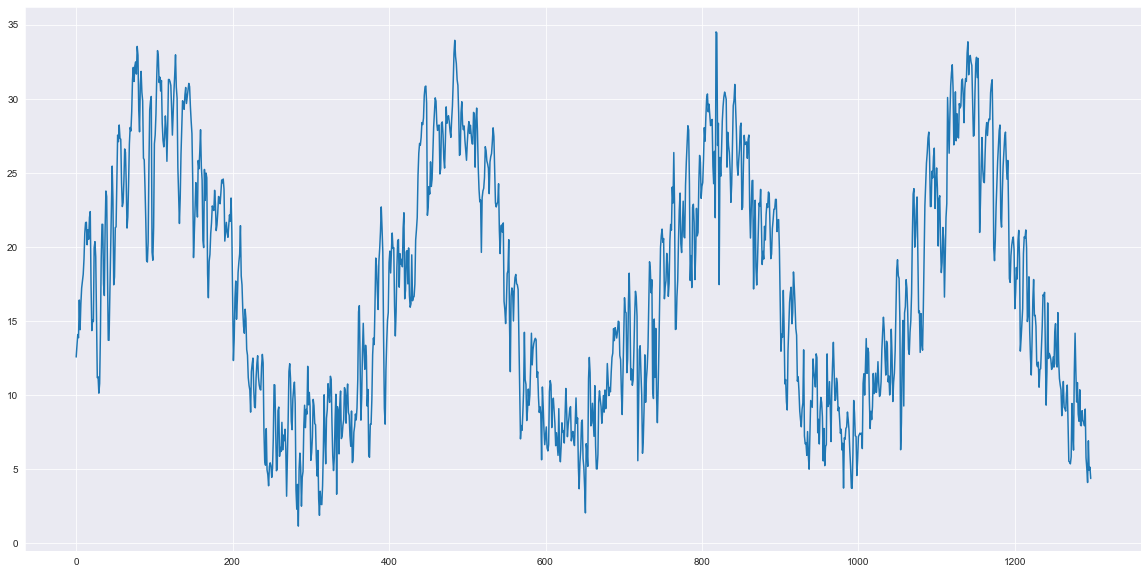

In [43]:
plot = data_serie_temp['TEMPERATURA'].plot(figsize=(20, 10))

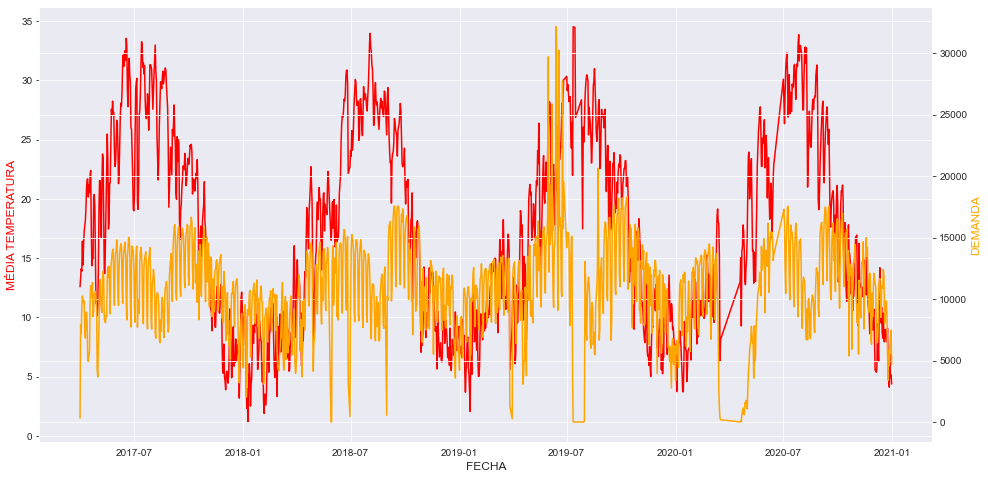

In [103]:
# create figure and axis objects with subplots()
plt.rcParams["figure.figsize"] = (16,8)
fig, ax = plt.subplots()
# make a plot
ax.plot(data_serie_temp['FECHA'],
        data_serie_temp['TEMPERATURA'],
        color="red")
# set x-axis label
ax.set_xlabel('FECHA', fontsize = 12)
# set y-axis label
ax.set_ylabel('MÉDIA TEMPERATURA',
              color="red",
              fontsize=12)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data_serie_temp['FECHA'], data_serie_temp['DEMANDA'],color="orange")
ax2.set_ylabel('DEMANDA',color="orange",fontsize=12)
plt.show()

In [85]:
# Measuring correlation between two variables
data_serie_temp[['DEMANDA','TEMPERATURA']].corr()

,DEMANDA,TEMPERATURA
DEMANDA,1.0,0.343764894715002
TEMPERATURA,0.343764894715002,1.0


**CONCLUSIÓN**: Temperatura y Demanda están muy correlacionados, por lo que Temperatura ccertamente será una varaiable muy predictora.

<AxesSubplot:xlabel='DEMANDA', ylabel='TEMPERATURA'>

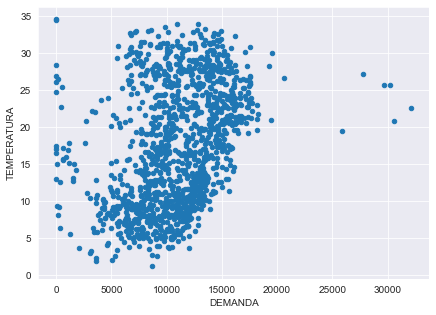

In [86]:
# Visualizing correlation between two variables using scatter plot
data_serie_temp.plot.scatter(x='DEMANDA', y='TEMPERATURA', marker='o', figsize=(7,5))

### b. EDA: 'TEMP_SENS_TERMC'

In [61]:
data_serie['TEMP_SENS_TERMC'].describe()

count        13,897,753.0
mean     17.0881945073964
std     9.085914509644326
min                 -6.59
25%                  9.98
50%                 17.15
75%                  24.7
max                 39.88
Name: TEMP_SENS_TERMC, dtype: float64

In [65]:
"""Chequear si hay valores raros de temperatura muy negativas"""
print("num de obs. con Sensación < -5°C =", data_serie.loc[data_serie['TEMP_SENS_TERMC'] < -5]['ANIO'].count())
print("num de obs. con Sensación < -10°C =", data_serie.loc[data_serie['TEMP_SENS_TERMC'] < -10]['ANIO'].count())
print("num de obs. con Sensación < -15°C =", data_serie.loc[data_serie['TEMP_SENS_TERMC'] < -15]['ANIO'].count())
print("num de obs. con Sensación < -20°C =", data_serie.loc[data_serie['TEMP_SENS_TERMC'] < -20]['ANIO'].count())

num de obs. con Sensación < -5°C = 4945
num de obs. con Sensación < -10°C = 0
num de obs. con Sensación < -15°C = 0
num de obs. con Sensación < -20°C = 0


In [66]:
"""Chequear si hay valores raros de temperatura muy altas"""
print("num de obs. con Sensación > 42°C =", data_serie.loc[data_serie['TEMP_SENS_TERMC'] > 42]['ANIO'].count())
print("num de obs. con Sensación > 44°C =", data_serie.loc[data_serie['TEMP_SENS_TERMC'] > 43]['ANIO'].count())
print("num de obs. con Sensación > 46°C =", data_serie.loc[data_serie['TEMP_SENS_TERMC'] > 44]['ANIO'].count())
print("num de obs. con Sensación > 48°C =", data_serie.loc[data_serie['TEMP_SENS_TERMC'] > 45]['ANIO'].count())

num de obs. con Sensación > 42°C = 0
num de obs. con Sensación > 44°C = 0
num de obs. con Sensación > 46°C = 0
num de obs. con Sensación > 48°C = 0


<AxesSubplot:title={'center':'TEMP_SENS_TERMC'}, xlabel='MES'>

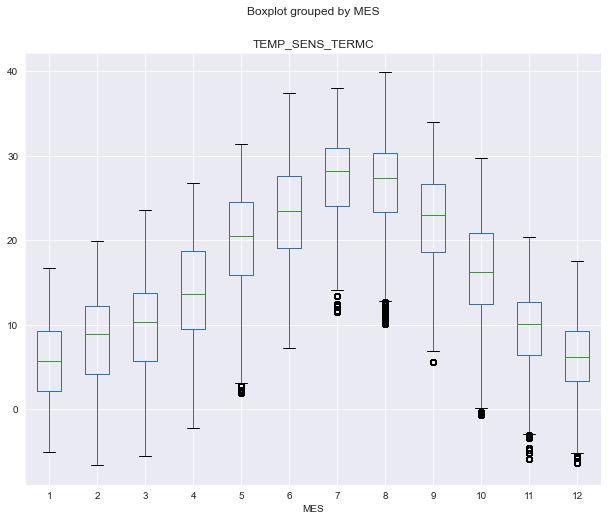

In [67]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
data_serie.boxplot('TEMP_SENS_TERMC', by='MES', ax=ax)

<AxesSubplot:xlabel='MES', ylabel='TEMP_SENS_TERMC'>

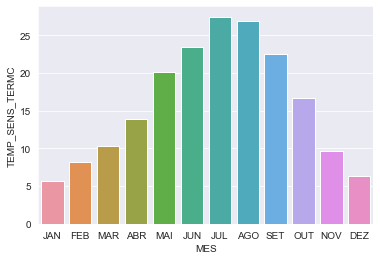

In [71]:
data_mes = data_serie[['MES','TEMP_SENS_TERMC']]
data_mes = data_mes.groupby(['MES']).agg(TEMP_SENS_TERMC=('TEMP_SENS_TERMC', 'mean'))   
data_mes = data_mes.reset_index() 
conditionlist = [
    (data_mes['MES'] == 1),
    (data_mes['MES'] == 2),
    (data_mes['MES'] == 3),
    (data_mes['MES'] == 4),
    (data_mes['MES'] == 5),
    (data_mes['MES'] == 6),
    (data_mes['MES'] == 7),
    (data_mes['MES'] == 8),
    (data_mes['MES'] == 9),
    (data_mes['MES'] == 10),
    (data_mes['MES'] == 11),
    (data_mes['MES'] == 12)]
choicelist = ['JAN','FEB','MAR','ABR','MAI','JUN','JUL','AGO','SET','OUT','NOV','DEZ']
data_mes['MES'] = np.select(conditionlist, choicelist, default='Not Specified')
sns.barplot(x = 'MES', y = 'TEMP_SENS_TERMC', data = data_mes) 

In [72]:
data_mes_anio = data_serie[['ANIO','MES','TEMP_SENS_TERMC']]
data_mes_anio = data_mes_anio.groupby(['ANIO','MES']).agg(TEMPERATURA=('TEMP_SENS_TERMC', 'mean'))   
data_mes_anio = data_mes_anio.reset_index() 
data_mes_anio

,ANIO,MES,TEMPERATURA
0,2017,3,11.03999999999997
1,2017,4,15.793179532835339
2,2017,5,21.19361645509818
3,2017,6,26.479669828468772
4,2017,7,27.27528467459218
5,2017,8,26.71279893705199
6,2017,9,21.98922301488671
7,2017,10,19.094856453765917
8,2017,11,9.625741865856794
9,2017,12,5.2706431727770084


**CONCLUSIÓN**: Misma conclusión para TEMPERATURA

#### b1. Correlación 

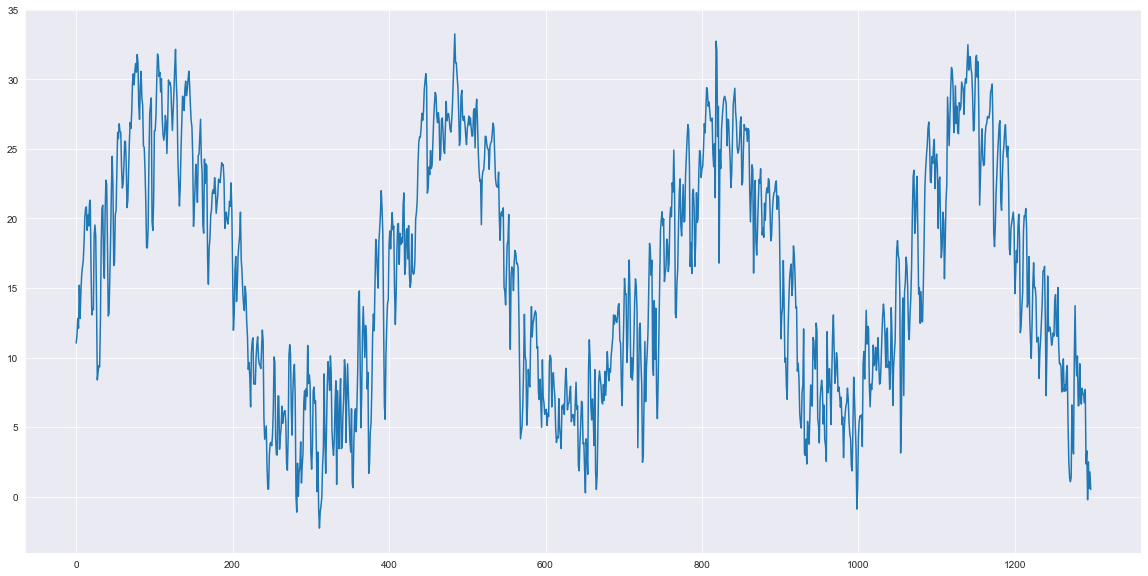

In [74]:
plot = data_serie_temp['TEMP_SENS_TERMC'].plot(figsize=(20, 10))

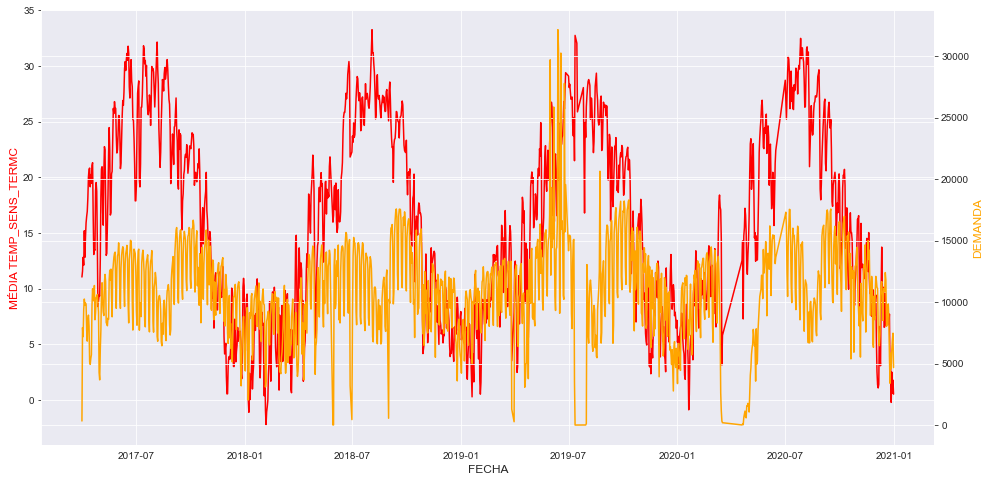

<Figure size 1152x576 with 0 Axes>

In [105]:
# create figure and axis objects with subplots()
plt.rcParams["figure.figsize"] = (16,8)
fig, ax = plt.subplots()
# make a plot
ax.plot(data_serie_temp['FECHA'],
        data_serie_temp['TEMP_SENS_TERMC'],
        color="red")
# set x-axis label
ax.set_xlabel('FECHA', fontsize = 12)
# set y-axis label
ax.set_ylabel('MÉDIA TEMP_SENS_TERMC',
              color="red",
              fontsize=12)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data_serie_temp['FECHA'], data_serie_temp['DEMANDA'],color="orange")
ax2.set_ylabel('DEMANDA',color="orange",fontsize=12)
plt.figure()
plt.show()

In [87]:
# Measuring correlation between two variables
data_serie_temp[['DEMANDA','TEMP_SENS_TERMC']].corr()

,DEMANDA,TEMP_SENS_TERMC
DEMANDA,1.0,0.3516946212304593
TEMP_SENS_TERMC,0.3516946212304593,1.0


<AxesSubplot:xlabel='DEMANDA', ylabel='TEMP_SENS_TERMC'>

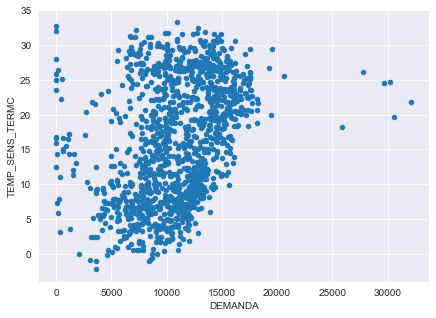

In [88]:
# Visualizing correlation between two variables using scatter plot
data_serie_temp.plot.scatter(x='DEMANDA', y='TEMP_SENS_TERMC', marker='o', figsize=(7,5))

### c. EDA: 'VIENTO'

In [106]:
data_serie['VIENTO'].describe()

count         13,897,753.0
mean    3.8186563789805548
std     2.3322028216864985
min                    0.0
25%                    2.1
50%                    3.1
75%                   5.14
max                  24.69
Name: VIENTO, dtype: float64

<AxesSubplot:title={'center':'VIENTO'}, xlabel='MES'>

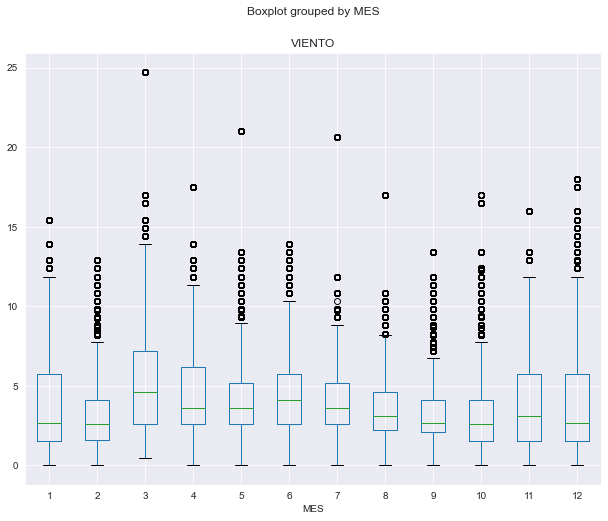

In [114]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
data_serie.boxplot('VIENTO', by='MES', ax=ax)

In [115]:
data_mes_anio = data_serie[['ANIO','MES','VIENTO']]
data_mes_anio = data_mes_anio.groupby(['ANIO','MES']).agg(TEMPERATURA=('VIENTO', 'mean'))   
data_mes_anio = data_mes_anio.reset_index() 
data_mes_anio

,ANIO,MES,TEMPERATURA
0,2017,3,7.71999999999998
1,2017,4,3.8235371597267407
2,2017,5,3.6856404701118595
3,2017,6,4.127987941517857
4,2017,7,3.941926871585932
5,2017,8,3.4305007726435583
6,2017,9,3.2626355323530665
7,2017,10,2.411384848047051
8,2017,11,2.781010416169785
9,2017,12,3.819759164031332


<AxesSubplot:xlabel='MES', ylabel='VIENTO'>

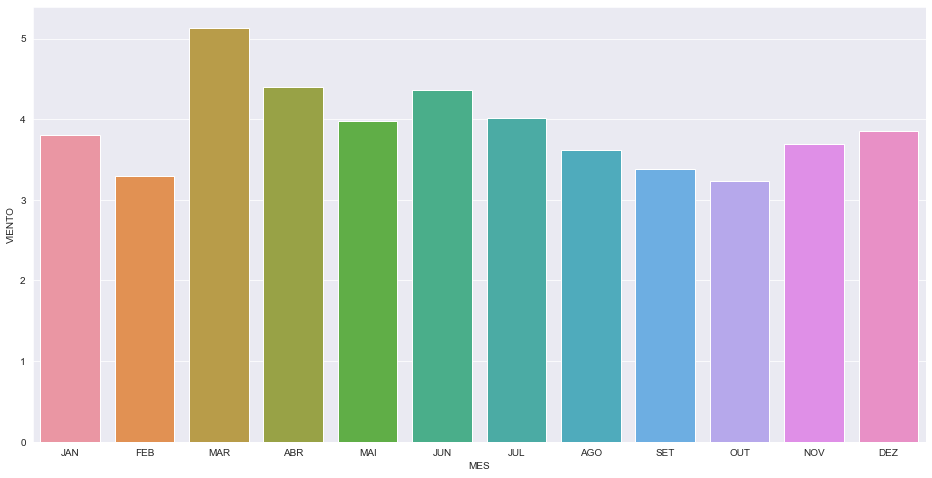

In [113]:
data_mes = data_serie[['MES','VIENTO']]
data_mes = data_mes.groupby(['MES']).agg(VIENTO=('VIENTO', 'mean'))   
data_mes = data_mes.reset_index() 
conditionlist = [
    (data_mes['MES'] == 1),
    (data_mes['MES'] == 2),
    (data_mes['MES'] == 3),
    (data_mes['MES'] == 4),
    (data_mes['MES'] == 5),
    (data_mes['MES'] == 6),
    (data_mes['MES'] == 7),
    (data_mes['MES'] == 8),
    (data_mes['MES'] == 9),
    (data_mes['MES'] == 10),
    (data_mes['MES'] == 11),
    (data_mes['MES'] == 12)]
choicelist = ['JAN','FEB','MAR','ABR','MAI','JUN','JUL','AGO','SET','OUT','NOV','DEZ']
data_mes['MES'] = np.select(conditionlist, choicelist, default='Not Specified')
sns.barplot(x = 'MES', y = 'VIENTO', data = data_mes) 

#### c1. Correlación 

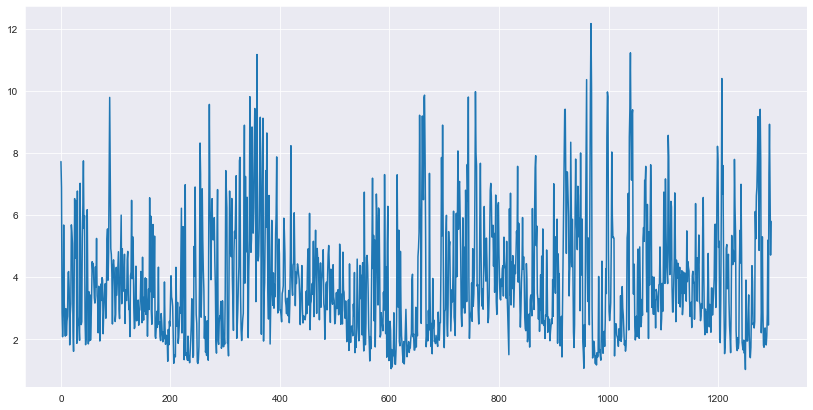

In [117]:
plot = data_serie_temp['VIENTO'].plot(figsize=(14, 7))

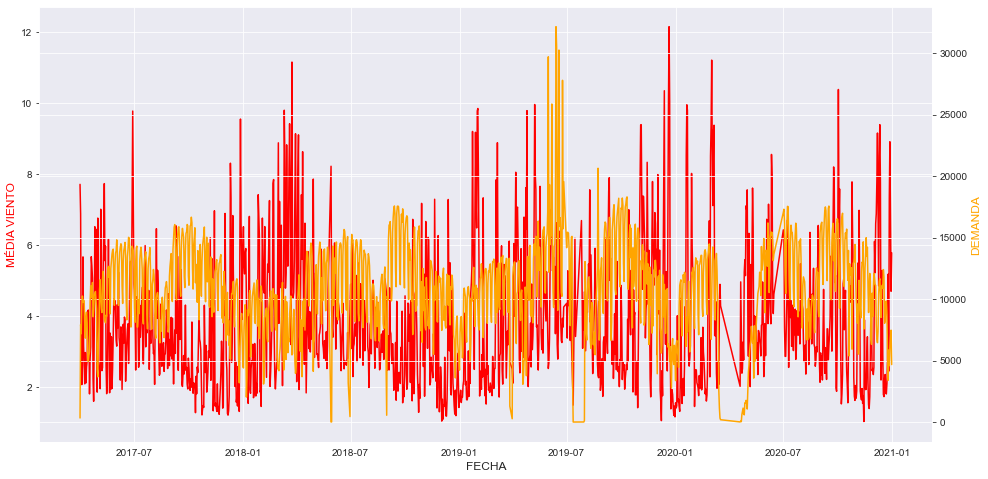

<Figure size 1152x576 with 0 Axes>

In [118]:
# create figure and axis objects with subplots()
plt.rcParams["figure.figsize"] = (16,8)
fig, ax = plt.subplots()
# make a plot
ax.plot(data_serie_temp['FECHA'],
        data_serie_temp['VIENTO'],
        color="red")
# set x-axis label
ax.set_xlabel('FECHA', fontsize = 12)
# set y-axis label
ax.set_ylabel('MÉDIA VIENTO',
              color="red",
              fontsize=12)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data_serie_temp['FECHA'], data_serie_temp['DEMANDA'],color="orange")
ax2.set_ylabel('DEMANDA',color="orange",fontsize=12)
plt.figure()
plt.show()

In [119]:
data_serie_temp[['DEMANDA','VIENTO']].corr()

,DEMANDA,VIENTO
DEMANDA,1.0,-0.10812056494855962
VIENTO,-0.10812056494855962,1.0


<AxesSubplot:xlabel='DEMANDA', ylabel='VIENTO'>

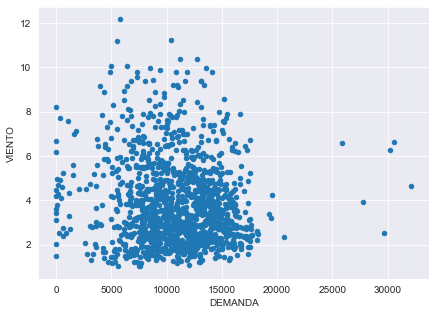

In [120]:
# Visualizing correlation between two variables using scatter plot
data_serie_temp.plot.scatter(x='DEMANDA', y='VIENTO', marker='o', figsize=(7,5))

### d. EDA: 'PRESION'

In [123]:
data_serie['PRESION'].describe()

count          13,897,753.0
mean    1,017.0202752919843
std       6.702962749806343
min                   982.0
25%                 1,013.0
50%                 1,017.0
75%                 1,021.0
max                 1,038.0
Name: PRESION, dtype: float64

<AxesSubplot:title={'center':'PRESION'}, xlabel='MES'>

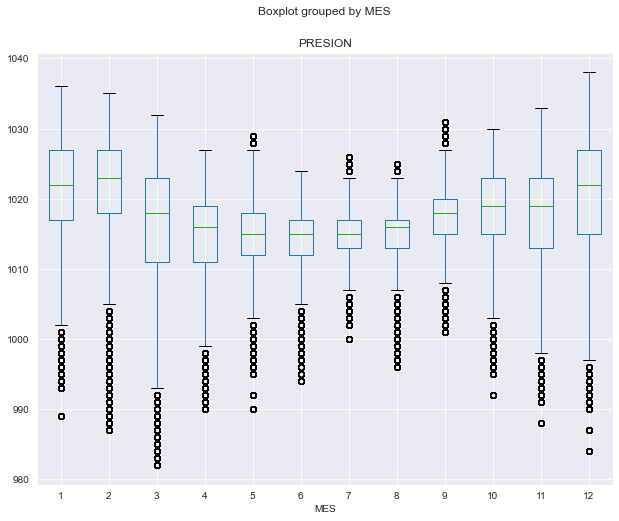

In [133]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
data_serie.boxplot('PRESION', by='MES', ax=ax)

<AxesSubplot:xlabel='MES', ylabel='PRESION'>

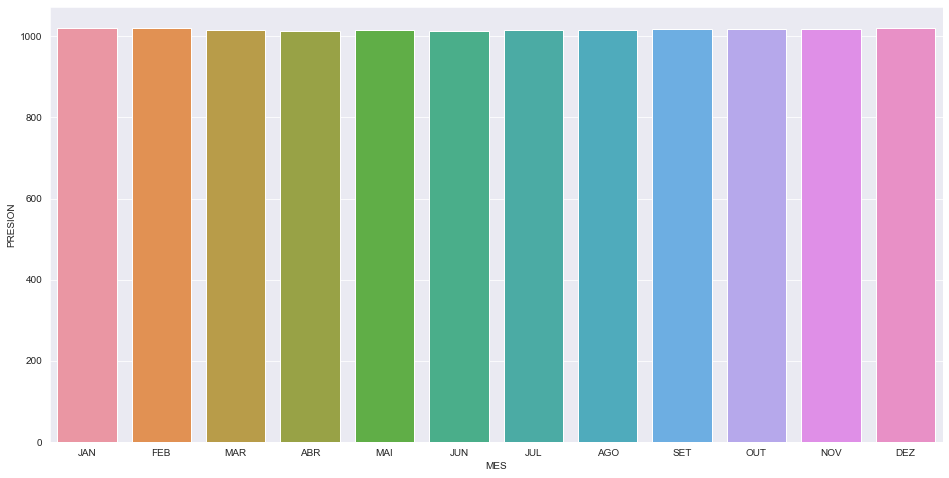

In [134]:
data_mes = data_serie[['MES','PRESION']]
data_mes = data_mes.groupby(['MES']).agg(PRESION=('PRESION', 'mean'))   
data_mes = data_mes.reset_index() 
conditionlist = [
    (data_mes['MES'] == 1),
    (data_mes['MES'] == 2),
    (data_mes['MES'] == 3),
    (data_mes['MES'] == 4),
    (data_mes['MES'] == 5),
    (data_mes['MES'] == 6),
    (data_mes['MES'] == 7),
    (data_mes['MES'] == 8),
    (data_mes['MES'] == 9),
    (data_mes['MES'] == 10),
    (data_mes['MES'] == 11),
    (data_mes['MES'] == 12)]
choicelist = ['JAN','FEB','MAR','ABR','MAI','JUN','JUL','AGO','SET','OUT','NOV','DEZ']
data_mes['MES'] = np.select(conditionlist, choicelist, default='Not Specified')
sns.barplot(x = 'MES', y = 'PRESION', data = data_mes) 

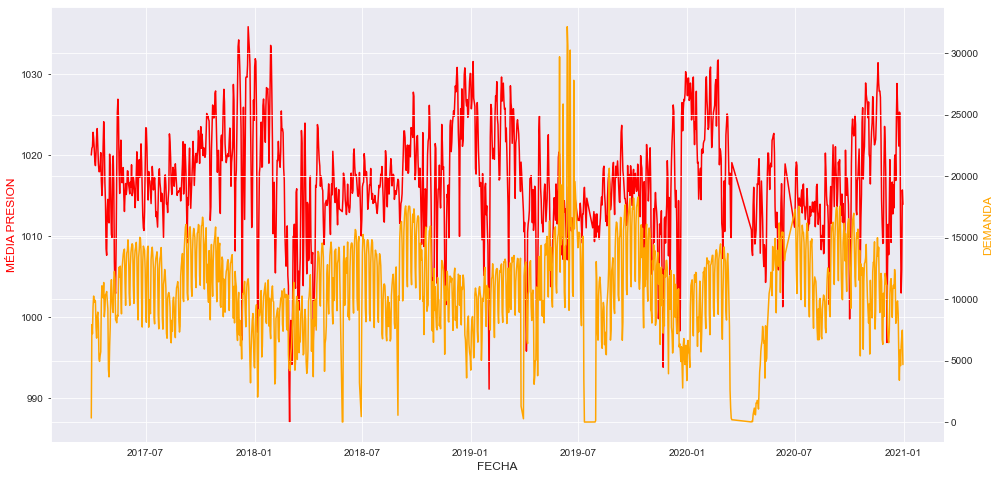

<Figure size 1152x576 with 0 Axes>

In [132]:
# create figure and axis objects with subplots()
plt.rcParams["figure.figsize"] = (16,8)
fig, ax = plt.subplots()
# make a plot
ax.plot(data_serie_temp['FECHA'],
        data_serie_temp['PRESION'],
        color="red")
# set x-axis label
ax.set_xlabel('FECHA', fontsize = 12)
# set y-axis label
ax.set_ylabel('MÉDIA PRESION',
              color="red",
              fontsize=12)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data_serie_temp['FECHA'], data_serie_temp['DEMANDA'],color="orange")
ax2.set_ylabel('DEMANDA',color="orange",fontsize=12)
plt.figure()
plt.show()

<AxesSubplot:xlabel='DEMANDA', ylabel='PRESION'>

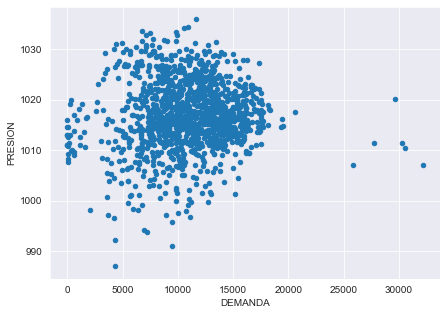

In [128]:
# Visualizing correlation between two variables using scatter plot
data_serie_temp.plot.scatter(x='DEMANDA', y='PRESION', marker='o', figsize=(7,5))

**CONCLUSIÓN**: Es practicamente constante. Se puede discutir si vale la pena poner en el modelo. Parece tener muy poca correlación con las demandas de bicimad.

### e. EDA: 'HUMEDAD'

In [53]:
data_serie['HUMEDAD'].describe()

count         13,897,753.0
mean     50.40387802258394
std     22.054898246745363
min                    6.0
25%                   32.0
50%                   47.0
75%                   67.0
max                  100.0
Name: HUMEDAD, dtype: float64

<AxesSubplot:title={'center':'HUMEDAD'}, xlabel='MES'>

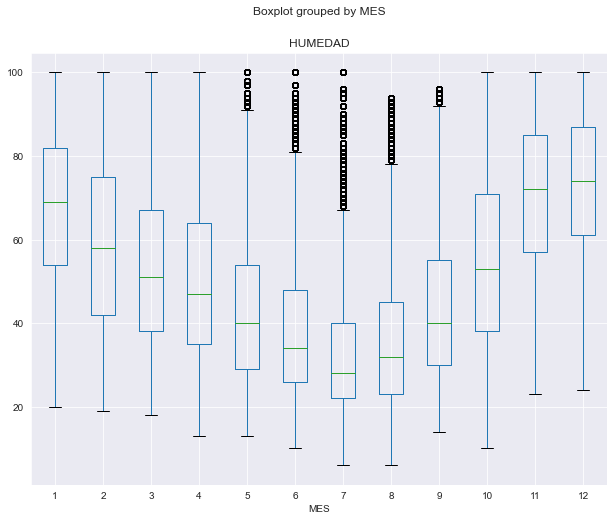

In [54]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
data_serie.boxplot('HUMEDAD', by='MES', ax=ax)

**OJO**: Hay unos outliers en los meses más secos.A lo mejor están correctos. 

<AxesSubplot:xlabel='MES', ylabel='HUMEDAD'>

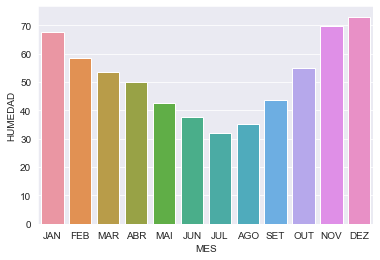

In [56]:
data_mes = data_serie[['MES','HUMEDAD']]
data_mes = data_mes.groupby(['MES']).agg(HUMEDAD=('HUMEDAD', 'mean'))   
data_mes = data_mes.reset_index() 
conditionlist = [
    (data_mes['MES'] == 1),
    (data_mes['MES'] == 2),
    (data_mes['MES'] == 3),
    (data_mes['MES'] == 4),
    (data_mes['MES'] == 5),
    (data_mes['MES'] == 6),
    (data_mes['MES'] == 7),
    (data_mes['MES'] == 8),
    (data_mes['MES'] == 9),
    (data_mes['MES'] == 10),
    (data_mes['MES'] == 11),
    (data_mes['MES'] == 12)]
choicelist = ['JAN','FEB','MAR','ABR','MAI','JUN','JUL','AGO','SET','OUT','NOV','DEZ']
data_mes['MES'] = np.select(conditionlist, choicelist, default='Not Specified')
sns.barplot(x = 'MES', y = 'HUMEDAD', data = data_mes) 

In [57]:
data_mes_anio = data_serie[['ANIO','MES','HUMEDAD']]
data_mes_anio = data_mes_anio.groupby(['ANIO','MES']).agg(HUMEDAD=('HUMEDAD', 'mean'))   
data_mes_anio = data_mes_anio.reset_index() 
data_mes_anio

,ANIO,MES,HUMEDAD
0,2017,3,44.0
1,2017,4,37.74315489083993
2,2017,5,39.429663058722
3,2017,6,31.53958156480842
4,2017,7,32.355403749470334
5,2017,8,35.57025314944379
6,2017,9,37.72523350739134
7,2017,10,45.4203099608566
8,2017,11,55.581591422387426
9,2017,12,65.84530043559623


#### e1. Correlación

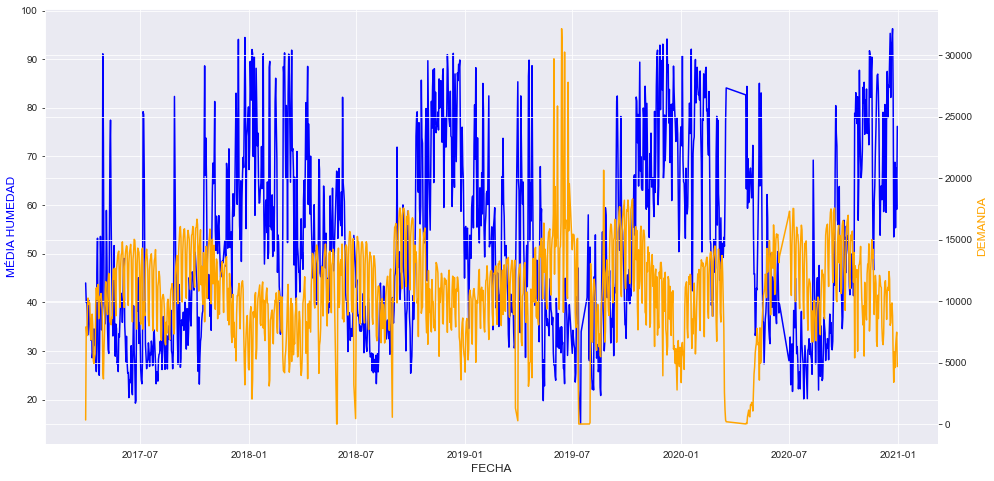

In [60]:
# create figure and axis objects with subplots()
plt.rcParams["figure.figsize"] = (16,8)
fig, ax = plt.subplots()
# make a plot
ax.plot(data_serie_temp['FECHA'],
        data_serie_temp['HUMEDAD'],
        color="blue")
# set x-axis label
ax.set_xlabel('FECHA', fontsize = 12)
# set y-axis label
ax.set_ylabel('MÉDIA HUMEDAD',
              color="blue",
              fontsize=12)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data_serie_temp['FECHA'], data_serie_temp['DEMANDA'],color="orange")
ax2.set_ylabel('DEMANDA',color="orange",fontsize=12)
plt.show()

In [75]:
# Measuring correlation between two variables
data_serie_temp[['HUMEDAD','DEMANDA']].corr()

,HUMEDAD,DEMANDA
HUMEDAD,1.0,-0.3201615591804738
DEMANDA,-0.3201615591804738,1.0


<AxesSubplot:xlabel='DEMANDA', ylabel='HUMEDAD'>

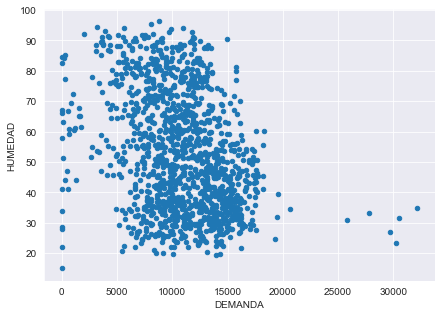

In [62]:
# Visualizing correlation between two variables using scatter plot
data_serie_temp.plot.scatter(x='DEMANDA', y='HUMEDAD', marker='o', figsize=(7,5))

**CONCLUSIÓN**: 

### f. EDA: 'PRECIPITACION_1h'

In [64]:
data_serie['PRECIPITACION_1h'].describe()

count           13,897,753.0
mean    0.043201014581299414
std       0.9619959579174072
min                      0.0
25%                      0.0
50%                      0.0
75%                      0.0
max                    46.99
Name: PRECIPITACION_1h, dtype: float64

<AxesSubplot:title={'center':'PRECIPITACION_1h'}, xlabel='MES'>

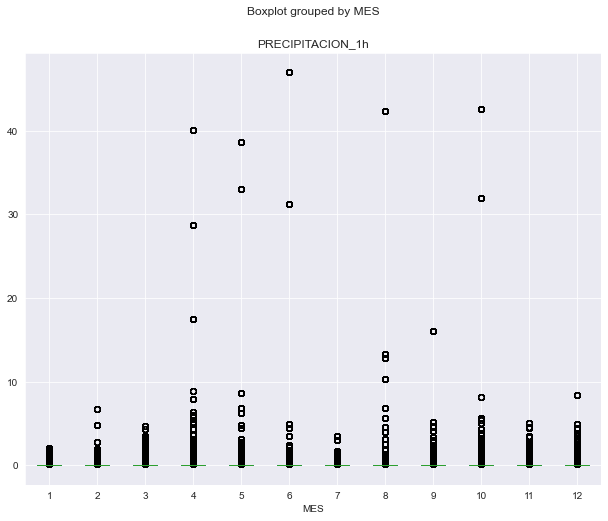

In [65]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
data_serie.boxplot('PRECIPITACION_1h', by='MES', ax=ax)

<AxesSubplot:xlabel='MES', ylabel='PRECIPITACION_1h'>

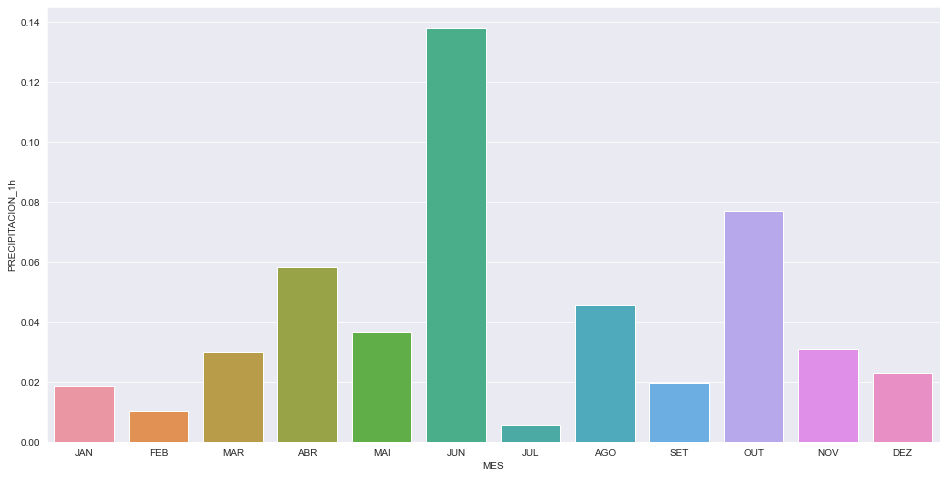

In [70]:
data_mes = data_serie[['MES','PRECIPITACION_1h']]
data_mes = data_mes.groupby(['MES']).agg(PRECIPITACION_1h=('PRECIPITACION_1h', 'mean'))   
data_mes = data_mes.reset_index() 
conditionlist = [
    (data_mes['MES'] == 1),
    (data_mes['MES'] == 2),
    (data_mes['MES'] == 3),
    (data_mes['MES'] == 4),
    (data_mes['MES'] == 5),
    (data_mes['MES'] == 6),
    (data_mes['MES'] == 7),
    (data_mes['MES'] == 8),
    (data_mes['MES'] == 9),
    (data_mes['MES'] == 10),
    (data_mes['MES'] == 11),
    (data_mes['MES'] == 12)]
choicelist = ['JAN','FEB','MAR','ABR','MAI','JUN','JUL','AGO','SET','OUT','NOV','DEZ']
data_mes['MES'] = np.select(conditionlist, choicelist, default='Not Specified')
sns.barplot(x = 'MES', y = 'PRECIPITACION_1h', data = data_mes) 

In [73]:
data_mes_anio = data_serie[['ANIO','MES','PRECIPITACION_1h']]
data_mes_anio = data_mes_anio.groupby(['ANIO','MES']).agg(PRECIPITACION_1h=('PRECIPITACION_1h', 'sum')) # Es la suma
data_mes_anio = data_mes_anio.reset_index() 
data_mes_anio

,ANIO,MES,PRECIPITACION_1h
0,2017,3,0.0
1,2017,4,505.9800000000017
2,2017,5,"2,403.880000000005"
3,2017,6,303.0100000000083
4,2017,7,"4,155.969999999946"
5,2017,8,"9,226.41000000009"
6,2017,9,16.100000000000026
7,2017,10,"3,754.740000000044"
8,2017,11,"1,903.229999999948"
9,2017,12,824.4000000000071


#### e1. Correlación

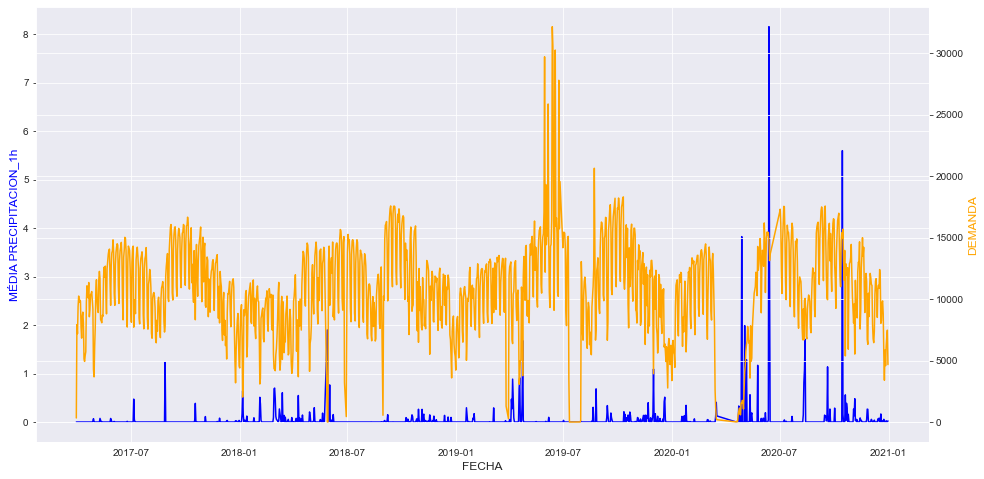

In [74]:
# create figure and axis objects with subplots()
plt.rcParams["figure.figsize"] = (16,8)
fig, ax = plt.subplots()
# make a plot
ax.plot(data_serie_temp['FECHA'],
        data_serie_temp['PRECIPITACION_1h'],
        color="blue")
# set x-axis label
ax.set_xlabel('FECHA', fontsize = 12)
# set y-axis label
ax.set_ylabel('MÉDIA PRECIPITACION_1h',
              color="blue",
              fontsize=12)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data_serie_temp['FECHA'], data_serie_temp['DEMANDA'],color="orange")
ax2.set_ylabel('DEMANDA',color="orange",fontsize=12)
plt.show()

In [77]:
# Measuring correlation between two variables
data_serie_temp[['PRECIPITACION_1h','DEMANDA']].corr()

,PRECIPITACION_1h,DEMANDA
PRECIPITACION_1h,1.0,-0.09139736379328084
DEMANDA,-0.09139736379328084,1.0


<AxesSubplot:xlabel='DEMANDA', ylabel='PRECIPITACION_1h'>

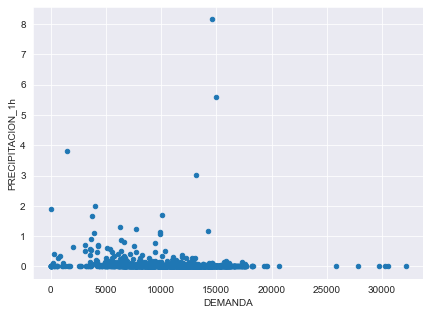

In [78]:
# Visualizing correlation between two variables using scatter plot
data_serie_temp.plot.scatter(x='DEMANDA', y='PRECIPITACION_1h', marker='o', figsize=(7,5))

**CONCLUSIÓN**: Parece tener correlación cuando "PRECIPITACION_1h" es diferente de zero. Pero todos los eventos de lluvia son muy poco frecuentes. 

### g. EDA: 'PRECIPITACION_3h'

In [81]:
data_serie['PRECIPITACION_3h'].describe()

count          13,897,753.0
mean    0.01548889234109689
std     0.32055068646800305
min                     0.0
25%                     0.0
50%                     0.0
75%                     0.0
max                   24.95
Name: PRECIPITACION_3h, dtype: float64

<AxesSubplot:title={'center':'PRECIPITACION_3h'}, xlabel='MES'>

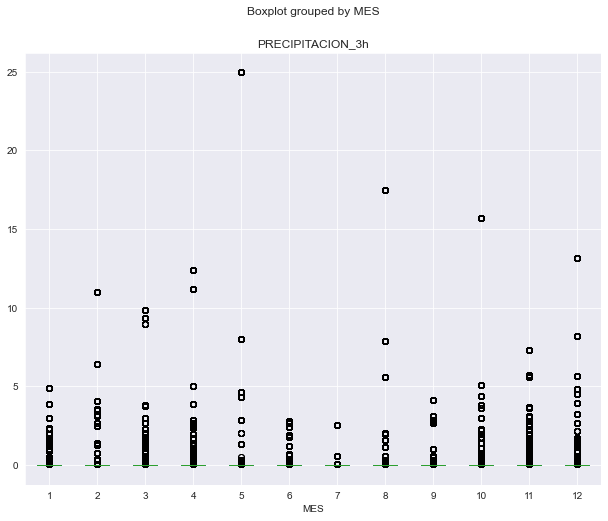

In [82]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
data_serie.boxplot('PRECIPITACION_3h', by='MES', ax=ax)

<AxesSubplot:xlabel='MES', ylabel='PRECIPITACION_3h'>

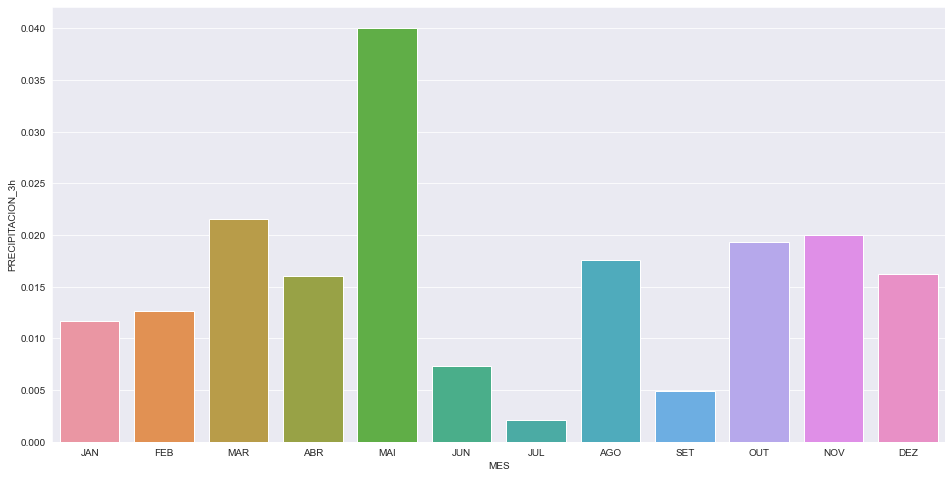

In [84]:
data_mes = data_serie[['MES','PRECIPITACION_3h']]
data_mes = data_mes.groupby(['MES']).agg(PRECIPITACION_3h=('PRECIPITACION_3h', 'mean'))   
data_mes = data_mes.reset_index() 
conditionlist = [
    (data_mes['MES'] == 1),
    (data_mes['MES'] == 2),
    (data_mes['MES'] == 3),
    (data_mes['MES'] == 4),
    (data_mes['MES'] == 5),
    (data_mes['MES'] == 6),
    (data_mes['MES'] == 7),
    (data_mes['MES'] == 8),
    (data_mes['MES'] == 9),
    (data_mes['MES'] == 10),
    (data_mes['MES'] == 11),
    (data_mes['MES'] == 12)]
choicelist = ['JAN','FEB','MAR','ABR','MAI','JUN','JUL','AGO','SET','OUT','NOV','DEZ']
data_mes['MES'] = np.select(conditionlist, choicelist, default='Not Specified')
sns.barplot(x = 'MES', y = 'PRECIPITACION_3h', data = data_mes) 

In [85]:
data_mes_anio = data_serie[['ANIO','MES','PRECIPITACION_3h']]
data_mes_anio = data_mes_anio.groupby(['ANIO','MES']).agg(PRECIPITACION_3h=('PRECIPITACION_3h', 'sum')) # Es la suma
data_mes_anio = data_mes_anio.reset_index() 
data_mes_anio

,ANIO,MES,PRECIPITACION_3h
0,2017,3,0.0
1,2017,4,0.0
2,2017,5,0.0
3,2017,6,0.0
4,2017,7,0.0
5,2017,8,"3,543.250000000093"
6,2017,9,0.0
7,2017,10,"7,939.650000000306"
8,2017,11,"1,197.7499999998597"
9,2017,12,"2,439.6499999999605"


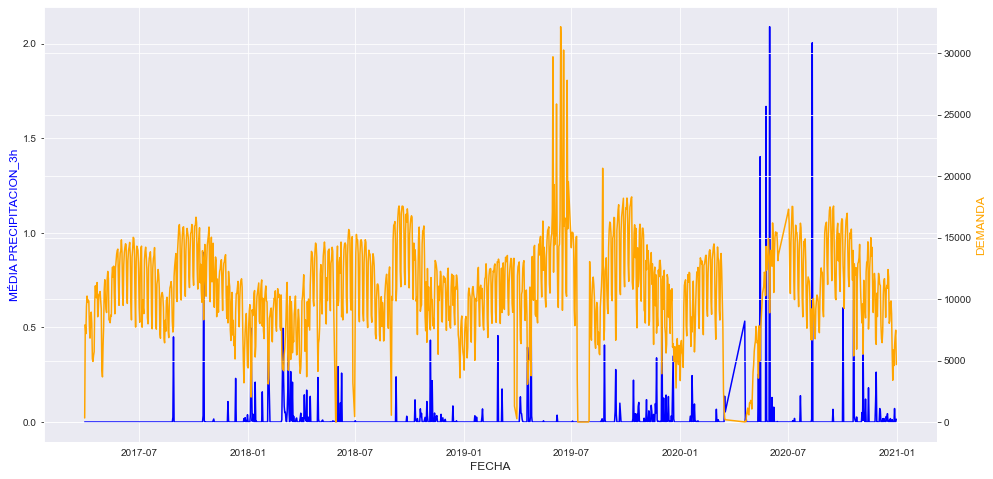

In [86]:
# create figure and axis objects with subplots()
plt.rcParams["figure.figsize"] = (16,8)
fig, ax = plt.subplots()
# make a plot
ax.plot(data_serie_temp['FECHA'],
        data_serie_temp['PRECIPITACION_3h'],
        color="blue")
# set x-axis label
ax.set_xlabel('FECHA', fontsize = 12)
# set y-axis label
ax.set_ylabel('MÉDIA PRECIPITACION_3h',
              color="blue",
              fontsize=12)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data_serie_temp['FECHA'], data_serie_temp['DEMANDA'],color="orange")
ax2.set_ylabel('DEMANDA',color="orange",fontsize=12)
plt.show()

In [87]:
# Measuring correlation between two variables
data_serie_temp[['PRECIPITACION_3h','DEMANDA']].corr()

,PRECIPITACION_3h,DEMANDA
PRECIPITACION_3h,1.0,-0.1600281978747731
DEMANDA,-0.1600281978747731,1.0


<AxesSubplot:xlabel='DEMANDA', ylabel='PRECIPITACION_3h'>

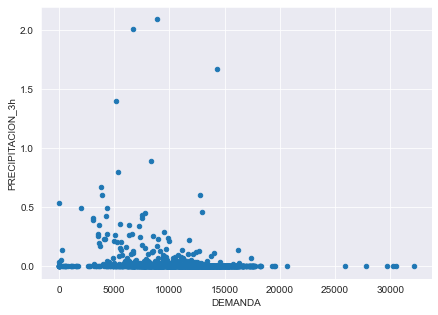

In [88]:
# Visualizing correlation between two variables using scatter plot
data_serie_temp.plot.scatter(x='DEMANDA', y='PRECIPITACION_3h', marker='o', figsize=(7,5))

**CONCLUSIÓN**: La misma que para la variable "PRECIPITACION_1h". 

### h. EDA: 'NIEVE_1h' y 'NIEVE_3h'

In [90]:
data_serie['NIEVE_1h'].describe()

count             13,897,753.0
mean    1.0105230680096299e-05
std      0.0019831379442862345
min                        0.0
25%                        0.0
50%                        0.0
75%                        0.0
max                       0.66
Name: NIEVE_1h, dtype: float64

In [96]:
data_serie['NIEVE_3h'].describe()

count   13,897,753.0
mean             0.0
std              0.0
min              0.0
25%              0.0
50%              0.0
75%              0.0
max              0.0
Name: NIEVE_3h, dtype: float64

<AxesSubplot:title={'center':'NIEVE_1h'}, xlabel='MES'>

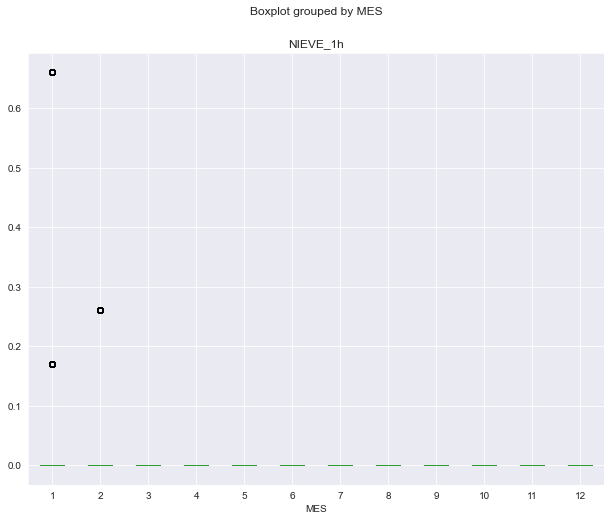

In [91]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
data_serie.boxplot('NIEVE_1h', by='MES', ax=ax)

<AxesSubplot:title={'center':'NIEVE_3h'}, xlabel='MES'>

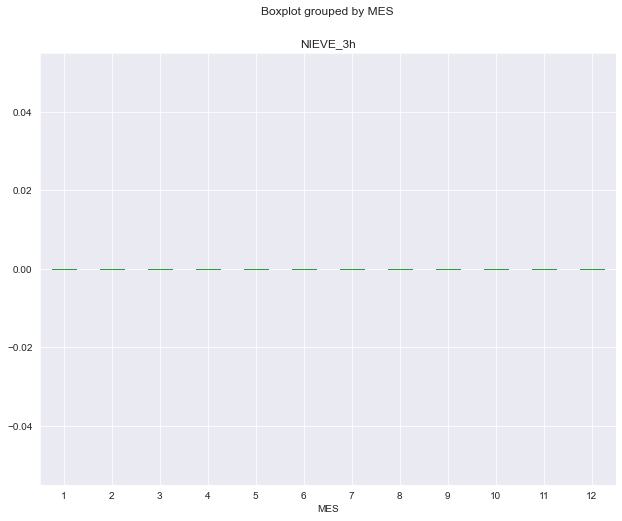

In [97]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
data_serie.boxplot('NIEVE_3h', by='MES', ax=ax)

<AxesSubplot:xlabel='MES', ylabel='NIEVE_1h'>

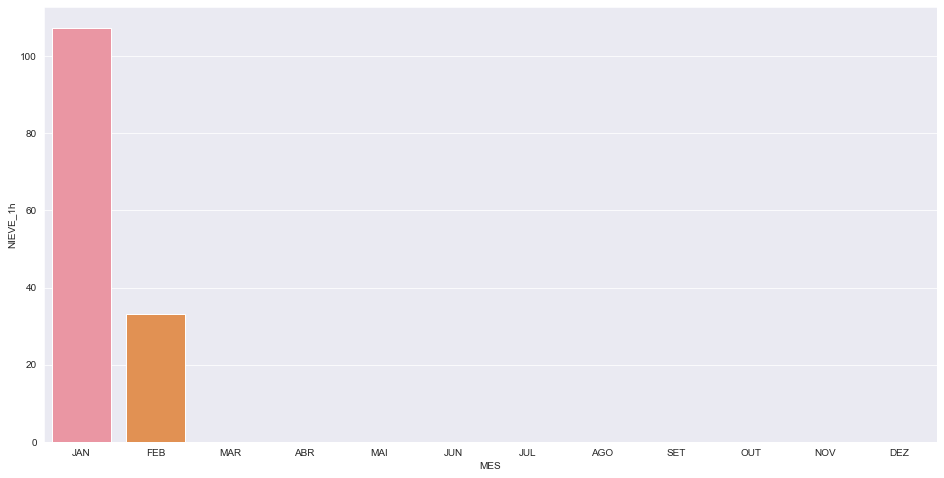

In [94]:
data_mes = data_serie[['MES','NIEVE_1h']]
data_mes = data_mes.groupby(['MES']).agg(NIEVE_1h=('NIEVE_1h', 'sum'))  
data_mes = data_mes.reset_index() 
conditionlist = [
    (data_mes['MES'] == 1),
    (data_mes['MES'] == 2),
    (data_mes['MES'] == 3),
    (data_mes['MES'] == 4),
    (data_mes['MES'] == 5),
    (data_mes['MES'] == 6),
    (data_mes['MES'] == 7),
    (data_mes['MES'] == 8),
    (data_mes['MES'] == 9),
    (data_mes['MES'] == 10),
    (data_mes['MES'] == 11),
    (data_mes['MES'] == 12)]
choicelist = ['JAN','FEB','MAR','ABR','MAI','JUN','JUL','AGO','SET','OUT','NOV','DEZ']
data_mes['MES'] = np.select(conditionlist, choicelist, default='Not Specified')
sns.barplot(x = 'MES', y = 'NIEVE_1h', data = data_mes) 

<AxesSubplot:xlabel='MES', ylabel='NIEVE_3h'>

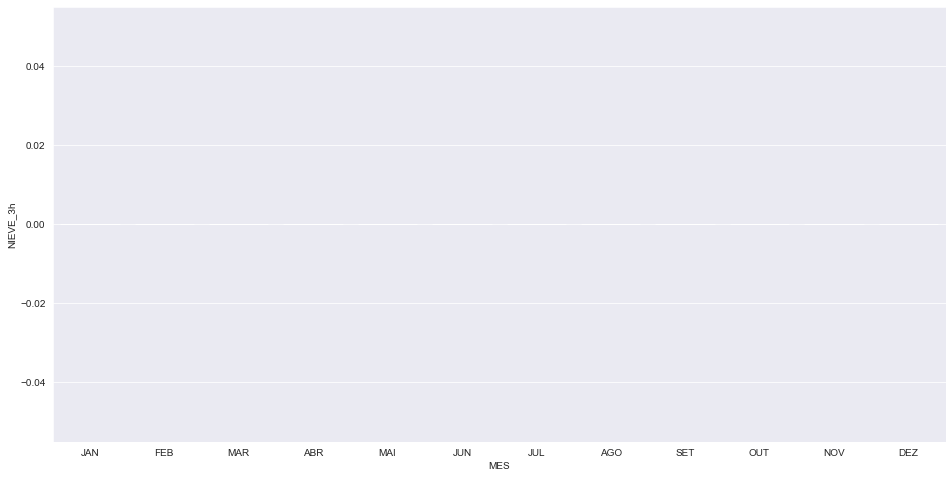

In [101]:
data_mes = data_serie[['MES','NIEVE_3h']]
data_mes = data_mes.groupby(['MES']).agg(NIEVE_3h=('NIEVE_3h', 'sum'))  
data_mes = data_mes.reset_index() 
conditionlist = [
    (data_mes['MES'] == 1),
    (data_mes['MES'] == 2),
    (data_mes['MES'] == 3),
    (data_mes['MES'] == 4),
    (data_mes['MES'] == 5),
    (data_mes['MES'] == 6),
    (data_mes['MES'] == 7),
    (data_mes['MES'] == 8),
    (data_mes['MES'] == 9),
    (data_mes['MES'] == 10),
    (data_mes['MES'] == 11),
    (data_mes['MES'] == 12)]
choicelist = ['JAN','FEB','MAR','ABR','MAI','JUN','JUL','AGO','SET','OUT','NOV','DEZ']
data_mes['MES'] = np.select(conditionlist, choicelist, default='Not Specified')
sns.barplot(x = 'MES', y = 'NIEVE_3h', data = data_mes) 

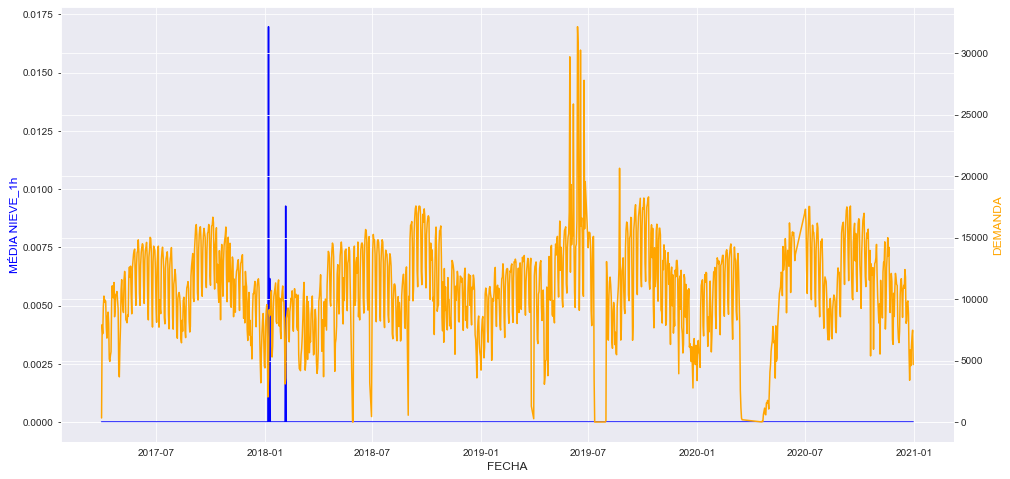

In [95]:
# create figure and axis objects with subplots()
plt.rcParams["figure.figsize"] = (16,8)
fig, ax = plt.subplots()
# make a plot
ax.plot(data_serie_temp['FECHA'],
        data_serie_temp['NIEVE_1h'],
        color="blue")
# set x-axis label
ax.set_xlabel('FECHA', fontsize = 12)
# set y-axis label
ax.set_ylabel('MÉDIA NIEVE_1h',
              color="blue",
              fontsize=12)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data_serie_temp['FECHA'], data_serie_temp['DEMANDA'],color="orange")
ax2.set_ylabel('DEMANDA',color="orange",fontsize=12)
plt.show()

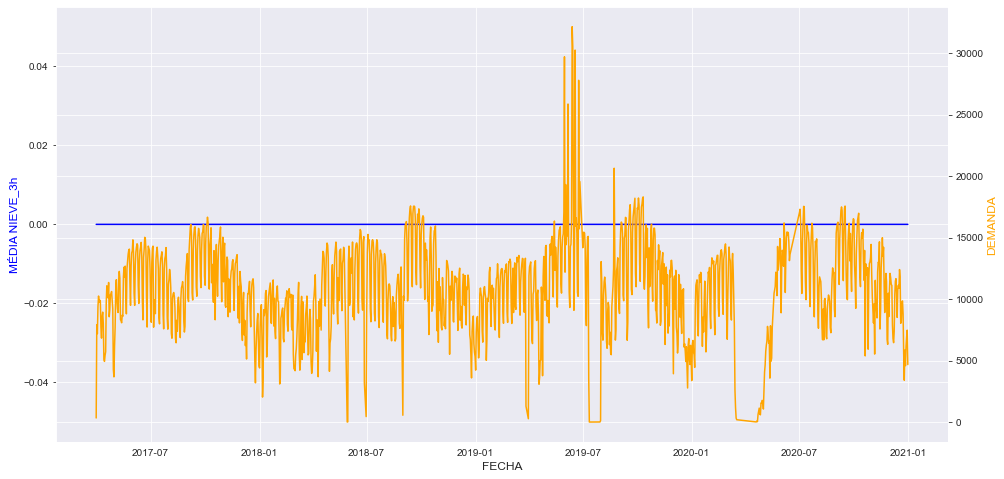

In [102]:
# create figure and axis objects with subplots()
plt.rcParams["figure.figsize"] = (16,8)
fig, ax = plt.subplots()
# make a plot
ax.plot(data_serie_temp['FECHA'],
        data_serie_temp['NIEVE_3h'],
        color="blue")
# set x-axis label
ax.set_xlabel('FECHA', fontsize = 12)
# set y-axis label
ax.set_ylabel('MÉDIA NIEVE_3h',
              color="blue",
              fontsize=12)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data_serie_temp['FECHA'], data_serie_temp['DEMANDA'],color="orange")
ax2.set_ylabel('DEMANDA',color="orange",fontsize=12)
plt.show()

**CONCLUSIÓN**: Las variables de nieve son absolutamente irrelevantes para el modelo. Las quitaría de la modelización.

## 2. Variables Categóricas

In [122]:
data_cat = data_final[['ID_TIPO_TIEMPO','DESC_TIEMPO', 'DESC_TIEMPO_detalle', 'DEMANDA']]
data_cat

,ID_TIPO_TIEMPO,DESC_TIEMPO,DESC_TIEMPO_detalle,DEMANDA
0,801.0,Clouds,few clouds,1
1,801.0,Clouds,few clouds,1
2,801.0,Clouds,few clouds,1
3,801.0,Clouds,few clouds,1
4,801.0,Clouds,few clouds,1
...,...,...,...,...
13897748,800.0,Clear,sky is clear,1
13897749,800.0,Clear,sky is clear,1
13897750,800.0,Clear,sky is clear,1
13897751,800.0,Clear,sky is clear,1


### a. EDA: 'ID_TIPO_TIEMPO'

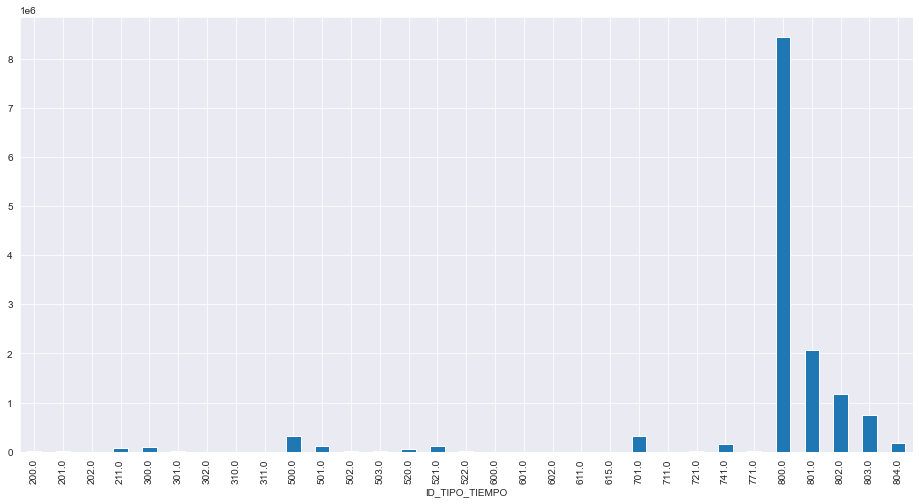

In [110]:
""" Barplot para la variable categórica """
k = data_cat.groupby(['ID_TIPO_TIEMPO']).size()
k.plot(kind='bar')
plt.show()

In [123]:
data_cat.groupby('ID_TIPO_TIEMPO').size().sort_values(ascending=False)

ID_TIPO_TIEMPO
800.0    8447230
801.0    2080746
802.0    1171560
803.0     754184
701.0     327010
500.0     322631
804.0     173014
741.0     149100
521.0     106461
501.0     105896
300.0      84409
211.0      66365
520.0      46162
301.0      19194
721.0      10803
502.0      10423
503.0       7211
522.0       3792
201.0       3566
200.0       2232
771.0       1508
310.0        863
202.0        745
600.0        737
601.0        534
311.0        467
711.0        395
615.0        272
611.0        153
602.0         75
302.0         15
dtype: int64

In [124]:
""" Transformar la variable ID_TIPO_TIEMPO en 10 variables dummy que nos permitan identificar 10 tipos de ID_TIPO_TIEMPO, 
    los 10 más comunes y el resto """
# Transformar la var ID_TIPO_TIEMPO en 10 categorias: (las var más frecuentes), y las demás en 'otras':

data_cat['ID_TIPO_TIEMPO'] = data_cat['ID_TIPO_TIEMPO'].apply(lambda x:x if (x == '800.0' or
                                                                             x == '801.0' or 
                                                                             x == '802.0' or
                                                                             x == '803.0' or
                                                                             x == '701.0' or
                                                                             x == '500.0') else 'Otros')
# Check
data_cat.groupby('ID_TIPO_TIEMPO').size().sort_values(ascending=False)

ID_TIPO_TIEMPO
800.0    8447230
801.0    2080746
802.0    1171560
Otros     794392
803.0     754184
701.0     327010
500.0     322631
dtype: int64

In [129]:
# Crear la variable dummy de la variable transformada:
data_cat = pd.get_dummies(data_cat, columns=['ID_TIPO_TIEMPO'] , prefix_sep='_', drop_first = True)
data_cat

,DESC_TIEMPO,DESC_TIEMPO_detalle,DEMANDA,ID_TIPO_TIEMPO_701.0,ID_TIPO_TIEMPO_800.0,ID_TIPO_TIEMPO_801.0,ID_TIPO_TIEMPO_802.0,ID_TIPO_TIEMPO_803.0,ID_TIPO_TIEMPO_Otros
0,Clouds,few clouds,1,0,0,1,0,0,0
1,Clouds,few clouds,1,0,0,1,0,0,0
2,Clouds,few clouds,1,0,0,1,0,0,0
3,Clouds,few clouds,1,0,0,1,0,0,0
4,Clouds,few clouds,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
13897748,Clear,sky is clear,1,0,1,0,0,0,0
13897749,Clear,sky is clear,1,0,1,0,0,0,0
13897750,Clear,sky is clear,1,0,1,0,0,0,0
13897751,Clear,sky is clear,1,0,1,0,0,0,0


### b. EDA: 'DESC_TIEMPO'

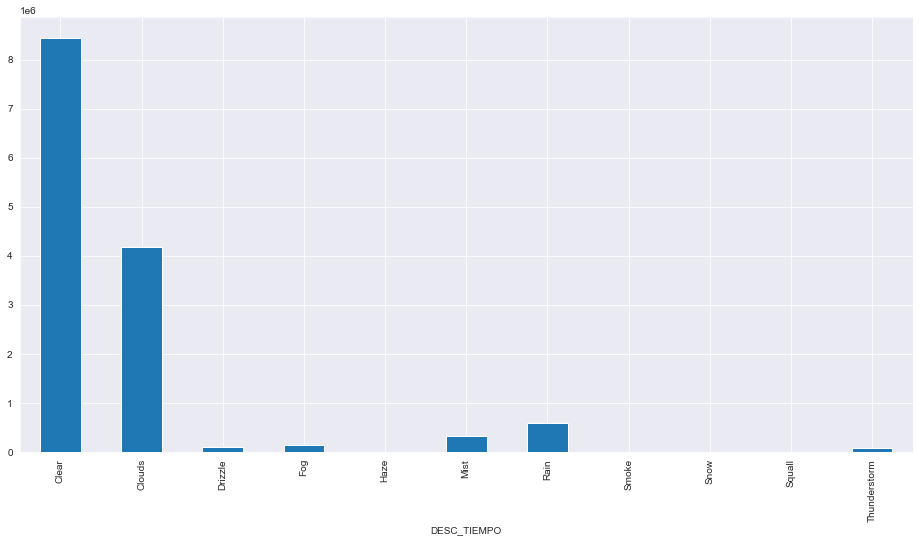

In [130]:
""" Barplot para la variable categórica """
k = data_cat.groupby(['DESC_TIEMPO']).size()
k.plot(kind='bar')
plt.show()

In [131]:
data_cat.groupby('DESC_TIEMPO').size().sort_values(ascending=False)

DESC_TIEMPO
Clear           8447230
Clouds          4179504
Rain             602576
Mist             327010
Fog              149100
Drizzle          104948
Thunderstorm      72908
Haze              10803
Snow               1771
Squall             1508
Smoke               395
dtype: int64

In [ ]:
data_cat['ID_TIPO_TIEMPO'] = data_cat['ID_TIPO_TIEMPO'].apply(lambda x:x if (x == '800.0' or
                                                                             x == '801.0' or 
                                                                             x == '802.0' or
                                                                             x == '803.0' or
                                                                             x == '701.0' or
                                                                             x == '500.0') else 'Otros')

In [ ]:
########################################## 

In [128]:
###############################
### Datos agregados por día ###
###############################

data_cat_dia = data_serie.groupby(['FECHA']).agg(ID_TIPO_TIEMPO=('ID_TIPO_TIEMPO','count'), 
                                                 DESC_TIEMPO=('DESC_TIEMPO','sum'),
                                                 DESC_TIEMPO_detalle=('DESC_TIEMPO_detalle','sum'), 
                                                 DEMANDA=('DEMANDA','sum'))   
data_cat_dia = data_cat_dia.reset_index()
data_cat_dia

,FECHA,ID_TIPO_TIEMPO,DESC_TIEMPO,DESC_TIEMPO_detalle,DEMANDA
0,2017-03-31,330,330,330,330
1,2017-04-01,7845,7845,7845,7917
2,2017-04-02,7108,7108,7108,7183
3,2017-04-03,9262,9262,9262,9388
4,2017-04-04,10163,10163,10163,10242
...,...,...,...,...,...
1293,2020-12-27,4575,4575,4575,4583
1294,2020-12-28,6153,6153,6153,6155
1295,2020-12-29,6917,6917,6917,6932
1296,2020-12-30,7360,7360,7360,7468


<AxesSubplot:xlabel='ID_TIPO_TIEMPO', ylabel='DEMANDA'>

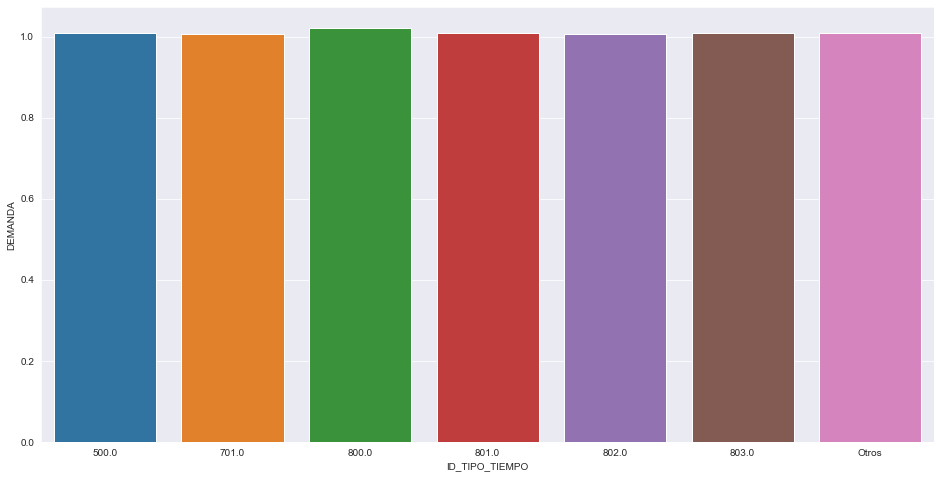

In [126]:
data_ID = data_cat[['ID_TIPO_TIEMPO','DEMANDA']]
data_ID = data_ID.groupby(['ID_TIPO_TIEMPO']).agg(DEMANDA=('DEMANDA', 'mean'))   
data_ID = data_ID.reset_index() 
sns.barplot(x="ID_TIPO_TIEMPO", y="DEMANDA", data=data_ID) 

In [127]:
data_ID

,ID_TIPO_TIEMPO,DEMANDA
0,500.0,1.0087747302646057
1,701.0,1.0068285373535977
2,800.0,1.021939026165974
3,801.0,1.0092221732013422
4,802.0,1.007445628051487
5,803.0,1.0076891050459835
6,Otros,1.0082868407536834


In [ ]:
cols = ['duration', 'count', 'srv_count', 'serror_rate', 'dst_host_srv_count', 'dst_host_srv_serror_rate', 
            'protocol_type', 'logged_in', 'service_private', 'flag_SF','flag_others' ]


for col in cols:
    plt.title(col)
    sns.countplot(x=col, hue='labels', data=pd_data)
    plt.show()

,ID_TIPO_TIEMPO,DESC_TIEMPO,DESC_TIEMPO_detalle,DEMANDA
0,801.0,Clouds,few clouds,1
1,801.0,Clouds,few clouds,1
2,801.0,Clouds,few clouds,1
3,801.0,Clouds,few clouds,1
4,801.0,Clouds,few clouds,1
...,...,...,...,...
13897748,800.0,Clear,sky is clear,1
13897749,800.0,Clear,sky is clear,1
13897750,800.0,Clear,sky is clear,1
13897751,800.0,Clear,sky is clear,1
